# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. 

Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Задача**

Имея набор данных, необходимо сделать предобработку данных и исследовательский анализ, для определения интересующих нас параметров. Узнать зависимость ценообразования от таких параметров, как населенный пункт, удаленнось, площадь и т.д.

На этапе предобработки будут:
- Найдены пропуски и заполнены данными, если это возможно;
- Изменен тип данных на необходимый для дальнейшей работыЖ
- Проведена обработка явных и неявных дубликатов;
- Устранены выбивающиеся значения, аномалии.

На этапе анализа данных будут изучены все данные по столбцам, построены гистограммы:
- будет дана оценка скорости продажи квартир;
- изучена зависимость стоимости квартиры от других параметров;
- будут обработаны самые популярные населенные пункты на сайте объявлений;
- вычислена стоимость "каждого километра" от центра Петербурга.

Первое, что необходимо сделать - ознакомиться с данными: узнать всю основную информацию о датафрейме, с которым нам предстоит работать.

### Изучение общей информации. 

Для начала импротируем библиотеки:

In [222]:
import pandas as pd #импортируем библиотеку pandas
import seaborn #импортируем библиотеку seaborn
import matplotlib.pyplot as plt 
#импортируем библиотеку matplotlib с помощью которой можно задавать 
#ограничения для boxplot, например

try:
    data = pd.read_csv('file:///E:/Practicum/2_Projects_Git/3_real_estate/real_estate_data.csv', sep='\t') 
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
#читаем таблицу, разделяем знаком табуляции и сохраняем в data

Читаем датасет и выводим информацию о ней:

In [223]:
data = data.rename(
    columns={'cityCenters_nearest': 'city_centers_nearest',
             'parks_around3000': 'parks_around_3_km',
             'ponds_around3000': 'ponds_around_3_km'}
) #переименование столбцов в удобно читаемый формат
data.info() #вывод информации о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [224]:
try:
    df = pd.read_csv('file:///E:/Practicum/2_Projects_Git/3_real_estate/real_estate_data.csv', sep='\t') 
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

In [225]:
display(data.head(10)) #показать датасет

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   
2             NaN           5.0        34.30      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0        32.00     13          NaN  ...   
5             NaN          12.0        14.40      5          NaN  ...   
6             NaN          26.0        10.60      6          NaN  ...   
7             NaN          24.0          NaN     22          NaN  ...   
8             NaN          27.0        15.43     26          NaN  ...   
9            2.50           9.0        43.60      7          NaN  ...   

   kitchen_area  balcony              locality_name  airports_nearest  \
0         25.00      NaN            Санкт-Петербург           18863.0   
1         11.00      2.0             посёлок Шушары           12817.0   
2          8.30      0.0            Санкт-Петербург           21741.0   
3           NaN      0.0            Санкт-Петербург           28098.0   
4         41.00      NaN            Санкт-Петербург           31856.0   
5          9.10      NaN  городской посёлок Янино-1               NaN   
6         14.40      1.0          посёлок Парголово           52996.0   
7         18.90      2.0            Санкт-Петербург           23982.0   
8          8.81      NaN             посёлок Мурино               NaN   
9          6.50      2.0            Санкт-Петербург           50898.0   

  city_centers_nearest  parks_around_3_km  parks_nearest  ponds_around_3_km  \
0              16028.0                1.0          482.0                2.0   
1              18603.0                0.0            NaN                0.0   
2              13933.0                1.0           90.0                2.0   
3               6800.0                2.0           84.0                3.0   
4               8098.0                2.0          112.0                1.0   
5                  NaN                NaN            NaN                NaN   
6              19143.0                0.0            NaN                0.0   
7              11634.0                0.0            NaN                0.0   
8                  NaN                NaN            NaN                NaN   
9              15008.0                0.0            NaN                0.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  
5            NaN             55.0  
6            NaN            155.0  
7            NaN              NaN  
8            NaN            189.0  
9            NaN            289.0  

[10 rows x 22 columns]

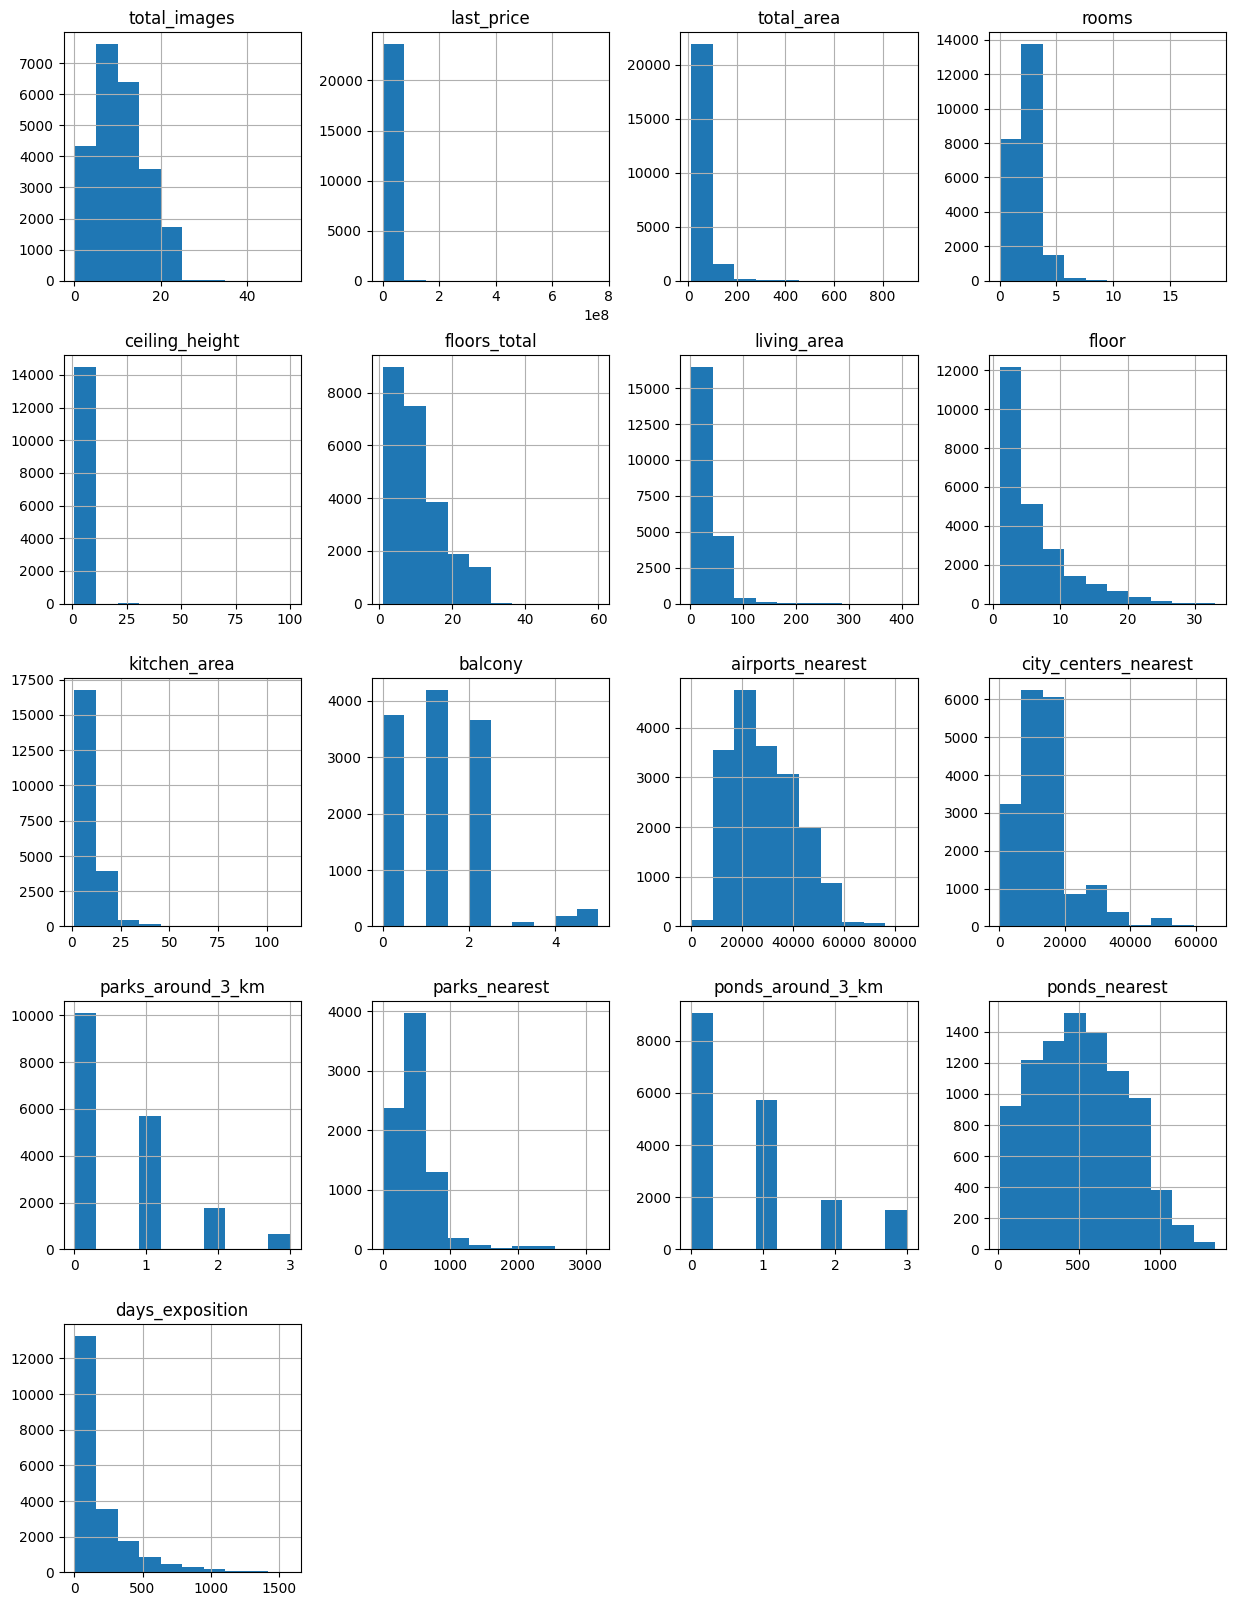

In [226]:
data.hist(figsize=(15, 20)); #построить гистограммы каждого столбца размером 15х20

Некоторые гистограммы выглядят неинформативными, например гистограмма `last_price`, там всего один столбец. Наверное, дело в масштабе.

Другие гистограммы выглядят, как что-то логичное, например, `parks_around_3_km` или `ponds_around_3_km`, где мы видим обычную закономерность: чем больше парков рядом - тем меньше таких квартир. Обычная логика.

Третьи гистограммы похожи на нормальное распределение, такие как `ponds_nearest`, или на распределение Пуассона, как `floors_total`.

В любом случае, все эти данные необходимо обработать: найти и заполнить пропуски, избавиться от аномалий и т.д.

Все это будет сделано в дальнейшем.

### Предобработка данных

In [227]:
# пропущенные значения бары

def pass_value_barh(data):  #
    try:
        (
            (data.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = 0, legend = False, fontsize = 14)
            .set_title('Количество пропусков' + "\n", fontsize = 20, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось')

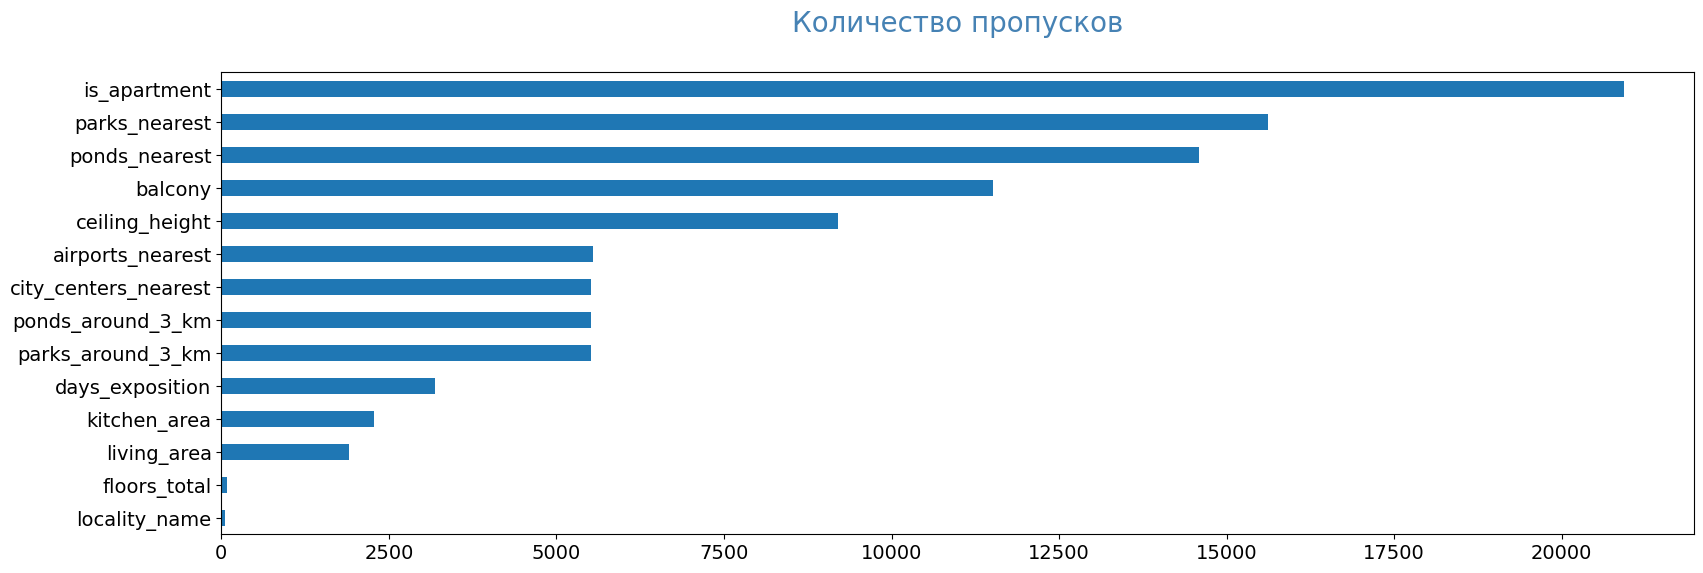

In [228]:
pass_value_barh(data)

В некоторох столбцах огомное количество пропусков, десятки тысяч, в некоторых - единицы. Есть такие, где пропусков вовсе нет.

Эту информацию нужно обработать.

#### Обработка пропущенных значений

**Какие пустые значения можно заполнить, а какие оставить?**

*В данном пункте не будут заполнены все пропуски, некоторые из них будут заполняться по мере обработки данных*

##### `ceiling_height`

- высота потолков. Потолки не могут не иметь высоты. Заменить на 0 нельзя. Среднее рассматривать не имеет смысла, т.к. слишком большой разброс может повлиять на результат, тут больше подходит медиана.

Построим диаграмму рассеяния высоты потолков в зависимости от расстояния до центра:

<AxesSubplot:xlabel='city_centers_nearest', ylabel='ceiling_height'>

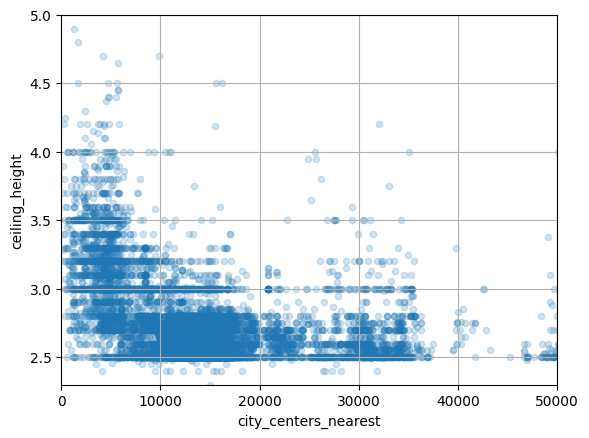

In [229]:
data.plot(x='city_centers_nearest', y='ceiling_height', kind='scatter',
          sharex=False, grid=True, xlim=(0,50000), ylim=(2.3,5), alpha=0.2)

На диаграмме отчетливо видно несколько зон высоты потолков. Это можно объяснить тем, что в Петербурге в старых районах потолки обычно выше, чем в новых. Ниже потолки также и в других населенных пунктах.
- первая зона - центр Петербурга. Наибольшее сосредоточение объектов до 6 000 метров;
- вторая зона - Петербург, более 6 000 метров от центра;
- третья зона - все остальные населенные пункты.

In [230]:
ceiling_peter_center_median = data.query(
    'locality_name == "Санкт-Петербург" & city_centers_nearest < 6000')['ceiling_height'].median()
# медиана высоты потолка для Петербурга с не более 6км от центра
ceiling_peter_not_center_median = data.query(
    'locality_name == "Санкт-Петербург" and city_centers_nearest >= 6000')['ceiling_height'].median()
# медиана высоты потолка для Петербурга с 6км от центра и дальше
ceiling_not_peter_median = data.query('locality_name != "Санкт-Петербург"')['ceiling_height'].median()
# медиана высоты потолка не для Петербурга

data.loc[
    (data['locality_name'] == "Санкт-Петербург") 
    & (data['city_centers_nearest'] < 6000)
    & (data['ceiling_height'].isnull()), 
    'ceiling_height'] = ceiling_peter_center_median
#заполняем пропуски в каждой категории медианным значением каждой категории

data.loc[
    (data['locality_name'] == "Санкт-Петербург") 
    & (data['city_centers_nearest'] >= 6000) 
    & (data['ceiling_height'].isnull()), 
    'ceiling_height'] = ceiling_peter_not_center_median

data.loc[
    (data['locality_name'] != "Санкт-Петербург") 
    & (data['ceiling_height'].isnull()), 
    'ceiling_height'] = ceiling_not_peter_median

In [231]:
data['ceiling_height'].isna().sum() #подсчет оставшихся пропущенных значений в столбце

30

Эти пропуски не подошли из-за отсутствия расстояний в нужных строках, т.к. условие по населенному пункту охватывает весь датасет, даже если нет информации о населенном пункте. Таких данных немного, можно идти дальше.

##### `floors_total`

- всего этажей в доме. Можно предположить, что если в доме 1 этаж, то это значение не указано. Нужно проверить:

In [232]:
how_many_floors = list(range(1, int(data['floors_total'].max()) + 1))
#создаем список из ранжировки от 1 до целочисленного максимального+1 значения столбца floors_total. 

floors_total_check = data.query('floors_total not in @how_many_floors') 
#фильтруем по значениям, не находящимся во внешнем списке how_many_floors (т.е. ищем NaN)

floors_total_check.groupby('floor')['floor'].count() 
#группировка по этажам продающихся квартир и подсчет их количества (это просто так)

floor
1      3
2      2
3      4
4     10
5      4
6      9
7      4
8      8
9      5
10     3
11     3
12     6
13     3
14     2
15     3
17     1
18     3
19     3
20     2
21     4
22     1
23     1
24     2
Name: floor, dtype: int64

Выяснили, что среди домов с неуказанным floors_total есть квартиры как на первом, так и на 24-м этаже. Следовательно, мы не можем сейчас заполнить пропуски.

##### `total_area` - граничное условие

Так как площадь квартиры не может состоять только из площади жилой зоны и кухни, необходимо ограничить эти площади. Также, в данных могут быть аномалии, где общая площадь меньше одной из частей.

Пусть площадь сан.узла, коридора и т.д. будет принята за 10%, тогда:

In [233]:
data = data.loc[
    (data['living_area'].isnull()) 
    | (data['kitchen_area'].isnull()) 
    | (data['total_area']*0.90 > (data['living_area'] + data['kitchen_area']))
].reset_index(drop=True)
#фильтр: или жилая площадь - пропуск 
#или площадь кухни - пропуск
#или 90% общей площади больше сумм остальных площадей
#восстановление индекса

In [234]:
data.shape

(23224, 22)

Потеряно 475 строк.

##### `living_area`  и `kitchen_area` обработка по граничному условию `total_area`

Так как известна общая площадь для всех квартир, и учитывая, что для нее уже установлено граничное условие выше, можно посчитать площадь для жилой зоны в пропущенных ячейках (при известной площади кухни), а площадь кухни (при известной жилой площади). Также стоит обратить внимание, что у студий площадь кухни равна нулю. Нужно это учесть.

После этого оставшиеся пропуски можно будет обработать методом расчета медиан отдельно для студий и отдельно для квартир с определенным количеством комнат.

In [235]:
data.loc[
    (data['living_area'].isnull()) 
    & (data['kitchen_area'] >= 0), 'living_area'] \
= data['total_area']*0.90 - data['kitchen_area'] 
data.loc[
    (data['kitchen_area'].isnull()) 
    & (data['living_area'] > 0)
    & (data['studio'] == False), 'kitchen_area'] \
= data['total_area']*0.90 - data['living_area'] 

##### `living_area`

Работа со студиями.

In [236]:
studio_check = data.query('studio==True') #фильтруем те помещения, которые относятся к студиям
display(studio_check.info()) #вывод на экран информации о студиях

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 143 to 23163
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          149 non-null    int64  
 1   last_price            149 non-null    float64
 2   total_area            149 non-null    float64
 3   first_day_exposition  149 non-null    object 
 4   rooms                 149 non-null    int64  
 5   ceiling_height        149 non-null    float64
 6   floors_total          146 non-null    float64
 7   living_area           139 non-null    float64
 8   floor                 149 non-null    int64  
 9   is_apartment          15 non-null     object 
 10  studio                149 non-null    bool   
 11  open_plan             149 non-null    bool   
 12  kitchen_area          0 non-null      float64
 13  balcony               91 non-null     float64
 14  locality_name         149 non-null    object 
 15  airports_nearest   

None

Мы видим, что имеется всего 149 студий.

Чтобы заполнить пропуски в жилой площади, понадобится тоже медиана, но не всех площадей, а сгруппированных определенным образом. Предлагаю вычислить медианы площадей исходя из количества комнат в квартире и деля недвижимость на категории квартира и студия.

In [237]:
is_studio = data.query('studio==True') #фильтр, является ли недвижимость студией
studio_rooms = is_studio['rooms'].value_counts() #Считаем количество студий с разным количеством комнат

pivot_studio = pd.pivot_table(is_studio, index=['rooms'], values='living_area', aggfunc='median')
#При помощи сводной таблицы находим медианное значение жилой площади студий с 1 и 0 комнатами
pivot_studio['studio_rooms'] = studio_rooms #Добавляем столбец с количеством студий по комнатам
display(pivot_studio)
studio_rooms_median_square = is_studio['living_area'].median() #медианная площадь студий

living_area  studio_rooms
rooms                           
0             18.0           138
1             18.0            11

Из данных выше видно, что медианная площать любых студий одинакова, значит неважно, сколько комнат в них будет указано, 0 или 1. 

Принимаем эту медиану за искомую площадь для неуказанных студий.

In [238]:
data.loc[(data['living_area'].isnull()) & (data['studio'] == True), 'living_area'] = studio_rooms_median_square
#Применяем логическую фильтрацию: если жилая площадь пустая И это студия, то заполняем жилую площадь медианным значением.
data['living_area'].isna().sum() #Сколько осталось объектов с незаполненными данными о жилой площади

1454

Переходим к квартирам:

In [239]:
flat = data.query('studio==False') #фильтр, является ли недвижимость квартирой
flat_rooms = flat['rooms'].value_counts() #Считаем количество квартир с разным количеством комнат

pivot_flat = pd.pivot_table(flat, index=['rooms'], values='living_area', aggfunc='median')
#При помощи сводной таблицы находим медианное значение жилой площади квартир с разным количеством комнат
pivot_flat['flat_rooms'] = flat_rooms #Добавляем столбец с количеством студий по комнатам
display(pivot_flat)

living_area  flat_rooms
rooms                         
0            18.00          59
1            17.60        7903
2            30.50        7796
3            45.00        5671
4            64.00        1142
5            91.80         316
6           123.90          98
7           146.10          59
8           161.00          12
9           179.20           8
10          161.40           3
11          133.90           2
12          409.70           1
14          195.15           2
15          409.00           1
16          180.00           1
19          264.50           1

Есть квартиры и с 0 комнат, а есть и с 19-ю. Выглядит неправдоподобно, но данные мы получили.

Нужно посмотреть, в квартирах со сколькими комнатами отсутствуют данные:

In [240]:
empty_area_flat = data.loc[(data['living_area'].isnull()) & (data['studio'] == False)]
#Применяем логическую фильтрацию: жилая площадь пустая И это квартира.
pivot_empty_area_flat = pd.pivot_table(empty_area_flat, index=['rooms'], values='last_price', aggfunc='count')
#Сводная таблица, показывающая, скольки-комнатные квартиры имеют пропуски в жилой площади, и какое их количество.
display(pivot_empty_area_flat)

last_price
rooms            
0               4
1             522
2             479
3             339
4              72
5              27
6               5
7               5
9               1

Каждое из значений количества комнат есть и в расчете медиан выше. Следовательно, обновить данные не составит труда.

In [241]:
list_rooms = list(pivot_empty_area_flat.index) #Создаем список из индексов (количества комнат) для последующих расчетов.

for room in list_rooms: #цикл: для каждого элемента в списке квартир (с пустыми данными о жилплощади)
    data.loc[
        (data['living_area'].isnull()) 
        & (data['studio'] == False) 
        & (data['rooms'] == room), 
        'living_area'] = pivot_flat['living_area'][room]
#Применяем логическую фильтрацию: 
#если (жилая площадь пустая) И (это квартира) И (количество комнат совпадает с элементом в итерации), 
#то заполняем жилую площадь медианным значением того количества комнат, какое совпадает с элементом в итерации

Проверим, не изменились ли медианные значения площадей и остались ли пустые значения в жилой площади:

In [242]:
display(pd.pivot_table(data, index=['rooms'], values='living_area', aggfunc='median')) 
#сводная таблица: индекс - комнаты, значения - медиана жилой площади по каждому количеству комнат
display(f"Сколько пропущенных значений осталось в living_area: {data['living_area'].isna().sum()}")

living_area
rooms             
0            18.00
1            17.60
2            30.50
3            45.00
4            64.00
5            91.80
6           123.90
7           146.10
8           161.00
9           179.20
10          161.40
11          133.90
12          409.70
14          195.15
15          409.00
16          180.00
19          264.50

'Сколько пропущенных значений осталось в living_area: 0'

##### `kitchen_area` 

- в предыдущей обработке стало ясно, что в студиях нет площади кухни, возможно потому, что кухня является частью жилой площади студии. Но это не дает ответ на все пропуски. Возможно, если рассмотреть открытую планировку, где нет ни одного пропуска, будет больше информации?

In [243]:
data.groupby('open_plan')['open_plan'].count() #сколько квартир со свободной планировкой? а сколько - без?

open_plan
False    23157
True        67
Name: open_plan, dtype: int64

Как видно из данных выше, квартир со свободной планировкой всего 67, это не может объяснить отсутствие данных.
Заменим недостающие значения медианными по тому же принципу, который использовали для жилой площади.

Студии:

In [244]:
data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == True), 'kitchen_area'] = 0 
#фильтр среди всех объявлений, где для студии с неизвестной площадью кухни эта площадь приравнивается 0

Квартиры:

In [245]:
pivot_flat_kitchen = pd.pivot_table(flat, index=['rooms'], values='kitchen_area', aggfunc='median') 
#При помощи сводной таблицы находим медианное значение площади кухни квартир с разным количеством комнат
pivot_flat_kitchen['flat_rooms'] = flat_rooms #Добавляем столбец с количеством квартир по комнатам

#код под # использовался ранее, добавил для отображения переменных, используемых и здесь

display(pivot_flat_kitchen)

kitchen_area  flat_rooms
rooms                          
0              5.69          59
1              9.00        7903
2              8.90        7796
3              9.60        5671
4             11.15        1142
5             15.20         316
6             20.00          98
7             20.00          59
8             25.50          12
9             14.30           8
10            19.80           3
11            12.60           2
12           112.00           1
14            21.25           2
15           100.00           1
16            13.00           1
19            27.60           1

Данные по квартирам мы получили.

Нужно посмотреть, в квартирах со сколькими комнатами отсутствуют данные:

In [246]:
empty_kitchen_area_flat = data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == False)]
#Применяем логическую фильтрацию: площадь кухни пустая И это квартира.
pivot_empty_kitchen_area_flat = pd.pivot_table(
    empty_kitchen_area_flat, index=['rooms'], values='last_price', aggfunc='count')
#Сводная таблица, показывающая, скольки-комнатные квартиры имеют пропуски в площади кухни, и какое их количество.
display(pivot_empty_kitchen_area_flat)

last_price
rooms            
0               4
1             522
2             479
3             339
4              72
5              27
6               5
7               5
9               1

Здесь есть особенность. Нужно проверить 0-комнатные квартиры (59 шт.), которые не являются студиями

Сравним такие квартиры со студиями:

- Медианная жилая площадь студий с 0 комнат = 18 м^2;
- Медианная жилая площадь студий с 1 комнатой = 18 м^2;
- Медианная жилая площадь квартир с 0 комнат = 18 м^2;
- Медианная жилая площадь квартир с 1 комнатой = 17,6 м^2.

Это довольно небольшой разброс, можно предположить, что при заполнении данных произошла ошибка, и все квартиры с 0 комнат - это студии, а все студии с 1 комнатой - это квартиры.

Вычислим медианные показатели жилой и, где это возможно, кухонной площади, а так же общую площадь помещений.

In [247]:
data_apartment = data.loc[
    ((data['rooms'] == 0) | (data['rooms'] == 1))]
#отбираем данные по нужным критериям (0 и 1 комнатные квартиры и студии в которых площадь кухни = 0 
#(студии, которым мы уже присвоили это значение) и без указанной площади)
pivot_data_apartment = pd.pivot_table(data_apartment, index=['studio', 'rooms'], values=['living_area', 'kitchen_area', 'total_area'], aggfunc='median')
#подготавливаем сводную таблицу данных
display(pivot_data_apartment)

kitchen_area  living_area  total_area
studio rooms                                       
False  0              5.69         18.0        26.1
       1              9.00         17.6        36.6
True   0              0.00         18.0        26.0
       1              0.00         18.0        27.0

Из этих данных видно, что действительно квартиры с 0 комнат больше похожи на струдии, но студии с 1 комнатой - это все еще студии. Поправим данные, в том числе медиану для площади кухни, которую мы сами и указали для квартир с 0 комнат.

In [248]:
data.loc[(data['rooms'] == 1) & (data['studio'] == True), 'rooms'] = 0 
#студии с 1 комнатой -> студии с 0 комнат
data.loc[(data['rooms'] == 0) & (data['studio'] == False), 'studio'] = True
#квартиры с 0 комнат -> студии с 0 комнат
data.loc[(data['kitchen_area'] != 0) & (data['studio'] == True), 'kitchen_area'] = 0

In [249]:
data_apartment = data.loc[
    ((data['rooms'] == 0) | (data['rooms'] == 1))]
pivot_data_apartment = pd.pivot_table(data_apartment, 
                                      index=['studio', 'rooms'],
                                      values=['living_area', 'kitchen_area', 'total_area'], aggfunc='mean').round(2)
display(pivot_data_apartment) #повторяем код для проверки с помощью среднего (проверит отклонения)
data['studio'].sum() #сколько стало студий

kitchen_area  living_area  total_area
studio rooms                                       
False  1              9.56        17.90       37.69
True   0              0.00        18.82       29.18

208

In [250]:
#повторяем код
empty_kitchen_area_flat = data.loc[(data['kitchen_area'].isnull()) & (data['studio'] == False)]
pivot_empty_kitchen_area_flat = pd.pivot_table(empty_kitchen_area_flat, 
                                               index=['rooms'], 
                                               values='last_price', aggfunc='count')
display(pivot_empty_kitchen_area_flat)

last_price
rooms            
1             522
2             479
3             339
4              72
5              27
6               5
7               5
9               1

Теперь все квартиры с 0 комнат стали студиями, площади их кухонь равны 0, а также все студии с 1 комнатой "лишились" её. Считаем медианные площади кухонь для квартир: 

In [251]:
list_rooms_kitchen = list(pivot_empty_kitchen_area_flat.index) 
#Создаем список из индексов (количества комнат) для последующих расчетов.

for room in list_rooms_kitchen: #цикл: для каждого элемента в списке квартир (с пустыми данными о площади кухни)
    data.loc[
        (data['kitchen_area'].isnull()) 
        & (data['studio'] == False) 
        & (data['rooms'] == room), 
        'kitchen_area'] = pivot_flat_kitchen['kitchen_area'][room]
#Применяем логическую фильтрацию: 
#если (площадь кухни пустая) И (это квартира) И (количество комнат совпадает с элементом в итерации),
#то заполняем площадь кухни медианным значением того количества комнат, какое совпадает с элементом в итерации

In [252]:
data['kitchen_area'].isnull().sum() #проверяем, остались ли пропуски

0

In [253]:
display(pd.pivot_table(data, index=['rooms'], values='kitchen_area', aggfunc='median')) #проверяем данные.

kitchen_area
rooms              
0              0.00
1              9.00
2              8.90
3              9.60
4             11.15
5             15.20
6             20.00
7             20.00
8             25.50
9             14.30
10            19.80
11            12.60
12           112.00
14            21.25
15           100.00
16            13.00
19            27.60

##### `is_apartment` 

- булев массив. Возможно, пропущенные значения - это не записанный False или даже True.

In [254]:
apartment = data['is_apartment'].value_counts() #считаем количество True и False среди сгруппированных по апартаментам квартир.
display(apartment)

False    2665
True       47
Name: is_apartment, dtype: int64

Так как в данных есть и False, и True, невозможно определить, какое значение несут пропуски в действительности.

Но принимая во внимание то, что апартаментов в сравнении с квартирами значительно меньше, примем, что пропущенные значения - это значения False.

In [255]:
data['is_apartment'] = data['is_apartment'].fillna(value=False) #Применяем значение к пропускам по всему столбцу

In [256]:
data.query('total_area * 0.9 > (living_area + kitchen_area)').reset_index(drop=True)

total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
21936             2   1350000.0       30.00  2017-07-07T00:00:00      1   
21937             9   4600000.0       62.40  2016-08-05T00:00:00      3   
21938             9   9700000.0      133.81  2017-03-21T00:00:00      3   
21939            14   3100000.0       59.00  2018-01-15T00:00:00      3   
21940             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70          16.0         51.0      8         False  ...   
1                2.60          11.0         18.6      1         False  ...   
2                2.64           5.0         34.3      4         False  ...   
3                2.64          14.0         45.0      9         False  ...   
4                3.03          14.0         32.0     13         False  ...   
...               ...           ...          ...    ...           ...  ...   
21936            2.60           5.0         17.5      4         False  ...   
21937            2.60           9.0         40.0      8         False  ...   
21938            3.70           5.0         73.3      3         False  ...   
21939            2.60           5.0         38.0      4         False  ...   
21940            2.50           5.0         12.3      1         False  ...   

       kitchen_area  balcony        locality_name  airports_nearest  \
0             25.00      NaN      Санкт-Петербург           18863.0   
1             11.00      2.0       посёлок Шушары           12817.0   
2              8.30      0.0      Санкт-Петербург           21741.0   
3              9.60      0.0      Санкт-Петербург           28098.0   
4             41.00      NaN      Санкт-Петербург           31856.0   
...             ...      ...                  ...               ...   
21936          6.00      NaN               Тихвин               NaN   
21937          8.00      0.0             Петергоф           45602.0   
21938         13.83      NaN      Санкт-Петербург           24665.0   
21939          8.50      NaN                Тосно               NaN   
21940          9.00      NaN  поселок Новый Учхоз               NaN   

      city_centers_nearest  parks_around_3_km  parks_nearest  \
0                  16028.0                1.0          482.0   
1                  18603.0                0.0            NaN   
2                  13933.0                1.0           90.0   
3                   6800.0                2.0           84.0   
4                   8098.0                2.0          112.0   
...                    ...                ...            ...   
21936                  NaN                NaN            NaN   
21937              34104.0                1.0          352.0   
21938               4232.0                1.0          796.0   
21939                  NaN                NaN            NaN   
21940                  NaN                NaN            NaN   

       ponds_around_3_km  ponds_nearest  days_exposition  
0                    2.0          755.0              NaN  
1                    0.0            NaN             81.0  
2                    2.0          574.0            558.0  
3                    3.0          234.0            424.0  
4                    1.0           48.0            121.0  
...                  ...            ...              ...  
21936                NaN            NaN            413.0  
21937                1.0          675.0            239.0  
21938           

##### Обработка отрицательной `delta`

<AxesSubplot:ylabel='Frequency'>

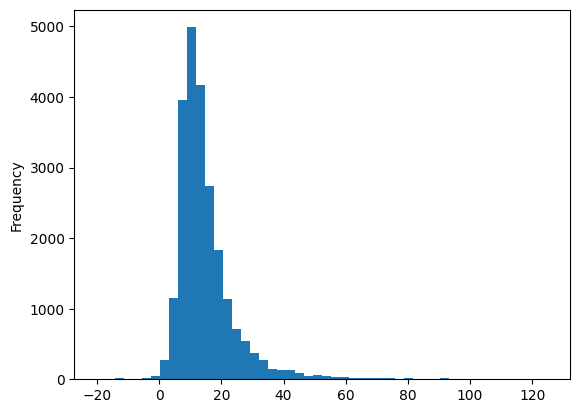

In [257]:
data['delta'] = data['total_area'] - data['living_area'] - data['kitchen_area']
data['delta'].plot(kind='hist', bins=50, range=(-20, 125))

Последний шаг. Имеются значения, где сумма площадей жилой зоны и кухни превышает общую площадь

In [258]:
data['delta'].sort_values().head()

14320   -65.50
12586   -40.00
14365   -37.90
11965   -35.60
12791   -33.15
Name: delta, dtype: float64

Сколько квартир с отрицательным `delta`?

In [259]:
data.loc[(data.loc[:, 'delta']) < 0, 'delta'].count() #считаем количество квартир, где общая площадь меньше сумм площадей

97

In [260]:
data.loc[:, ['total_area', 'living_area', 'kitchen_area', 'rooms', 'delta']].sort_values(by='delta', ascending=True).head(10)
#выводим полученный результат

total_area  living_area  kitchen_area  rooms  delta
14320       100.6        146.1         20.00      7 -65.50
12586        67.0         91.8         15.20      5 -40.00
14365       106.0        123.9         20.00      6 -37.90
11965        71.4         91.8         15.20      5 -35.60
12791        42.0         64.0         11.15      4 -33.15
19699        42.0         64.0         11.15      4 -33.15
9786         49.5         64.0         11.15      4 -25.65
17127        50.0         64.0         11.15      4 -25.15
16750        50.0         64.0         11.15      4 -25.15
18285        59.0         64.0         11.15      4 -16.15

Отсеиваем строки, которые не удовлетворяют условию:

In [261]:
data = data.query('delta > 0').reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23125 entries, 0 to 23124
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23125 non-null  int64  
 1   last_price            23125 non-null  float64
 2   total_area            23125 non-null  float64
 3   first_day_exposition  23125 non-null  object 
 4   rooms                 23125 non-null  int64  
 5   ceiling_height        23095 non-null  float64
 6   floors_total          23044 non-null  float64
 7   living_area           23125 non-null  float64
 8   floor                 23125 non-null  int64  
 9   is_apartment          23125 non-null  bool   
 10  studio                23125 non-null  bool   
 11  open_plan             23125 non-null  bool   
 12  kitchen_area          23125 non-null  float64
 13  balcony               11948 non-null  float64
 14  locality_name         23076 non-null  object 
 15  airports_nearest   

Мы обработали данные по `total_area`, `living_area` и `living_area`. В датасете не осталось строк с:
- суммарной площадью кухни и жилой площади, большей, чем 90% общей площади;
- квартир, где кухня больше жилой зоны;

In [262]:
# check
data[data['total_area']*0.9 <= (data ['living_area']+data ['kitchen_area'])][['total_area'
                                                                                  ,'living_area','kitchen_area']]

total_area  living_area  kitchen_area
7           71.60       45.540         18.90
115         97.20       69.180         18.30
154        317.00      183.000        102.30
163         40.30       30.500          8.90
164         60.20       43.980         10.20
...           ...          ...           ...
23029       43.40       30.500          8.90
23032       44.30       27.000         12.87
23082       40.50       19.600         16.85
23122       56.70       29.700         21.33
23123       76.75       45.775         23.30

[1184 rows x 3 columns]

In [263]:
# check
data.shape

(23125, 23)

##### `balcony`

- количество балконов. А может быть и их отсутствие?

In [264]:
pd.pivot_table(data, index=['balcony'], values=['total_area'], aggfunc='count') 
#группируем квартиры по количеству балконов в них с считаем, сколько квартир в каждой группе.

total_area
balcony            
0.0            3693
1.0            4121
2.0            3580
3.0              79
4.0             177
5.0             298

Среди квартир с балконами, есть квартиры с 0 балконов. Несмотря на это, мы все еще можем предполагать, что пустые значения - это квартиры без балконов, это не противоречит том, что мы видим. Эти пропуски можно заменить на 0. 

In [265]:
data['balcony'].fillna(value=0, inplace=True) #в каждом выбранном столбце заполняем нулями пробелы

##### `locality_name` 

- это название населенного пункта. Его не может не быть, но мы не знаем, к каким населенным(-ому) пунктам(-у) они относятся. 

Заменим пустые значения на "неизвестно".

In [266]:
data.loc[data['locality_name'].isnull(), 'locality_name'] = 'неизвестно' #Применяем значение к пропускам по всему столбцу

##### `parks_around_3_km` и `ponds_around_3_km`

- число парков и водоемов в радиусе 3 км соответственно. 

Здесь вполне возможно, что неуказанные данные означают, что в окресностях нет парков или водоемов. Также интересно то, что число квартир не имеющих данных для парков и водоемов одинаковое.

In [267]:
around_3_km = data[['parks_around_3_km', 'ponds_around_3_km']].query('parks_around_3_km.isnull()') 
#создаем таблицу для сравнения двух столбцов, оставляем только те значения в parks_around3000, которые NaN. 
around_3_km.info() #Выводим информацию.
around_3_km #Выводим датасет

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5347 entries, 5 to 23124
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parks_around_3_km  0 non-null      float64
 1   ponds_around_3_km  0 non-null      float64
dtypes: float64(2)
memory usage: 125.3 KB


parks_around_3_km  ponds_around_3_km
5                    NaN                NaN
8                    NaN                NaN
12                   NaN                NaN
22                   NaN                NaN
30                   NaN                NaN
...                  ...                ...
23109                NaN                NaN
23118                NaN                NaN
23121                NaN                NaN
23122                NaN                NaN
23124                NaN                NaN

[5347 rows x 2 columns]

Из информации по датасету видно, что после фильтра по `parks_around_3_km`, все значения в `parks_around_3_km` и `ponds_around_3_km` являются `NaN`, а количество строк равно количеству пропущенных значений в `data`. Отсюда следует, что в двух столбцах действительно данные об одних и тех же квартирах построчно.
В этих колонках можно заменить пропущенные данные на 0.

Нулями стоит заменить пустые значения в столбцах с:
- количеством балконов;
- количеством парков в радиусе 3 километров;
- количеством водоемов в радиусе 3 километров.

In [268]:
data.fillna({'parks_around_3_km':0, 'ponds_around_3_km':0}, inplace=True) #делаем то же самое, но с помощью словаря
data.head(10) #Вывод первых десяти строк

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0        51.00      8         False  ...   
1            2.60          11.0        18.60      1         False  ...   
2            2.64           5.0        34.30      4         False  ...   
3            2.64          14.0        45.00      9         False  ...   
4            3.03          14.0        32.00     13         False  ...   
5            2.60          12.0        14.40      5         False  ...   
6            2.60          26.0        10.60      6         False  ...   
7            2.64          24.0        45.54     22         False  ...   
8            2.60          27.0        15.43     26         False  ...   
9            2.50           9.0        43.60      7         False  ...   

   balcony              locality_name  airports_nearest  city_centers_nearest  \
0      0.0            Санкт-Петербург           18863.0               16028.0   
1      2.0             посёлок Шушары           12817.0               18603.0   
2      0.0            Санкт-Петербург           21741.0               13933.0   
3      0.0            Санкт-Петербург           28098.0                6800.0   
4      0.0            Санкт-Петербург           31856.0                8098.0   
5      0.0  городской посёлок Янино-1               NaN                   NaN   
6      1.0          посёлок Парголово           52996.0               19143.0   
7      2.0            Санкт-Петербург           23982.0               11634.0   
8      0.0             посёлок Мурино               NaN                   NaN   
9      2.0            Санкт-Петербург           50898.0               15008.0   

  parks_around_3_km  parks_nearest  ponds_around_3_km  ponds_nearest  \
0               1.0          482.0                2.0          755.0   
1               0.0            NaN                0.0            NaN   
2               1.0           90.0                2.0          574.0   
3               2.0           84.0                3.0          234.0   
4               2.0          112.0                1.0           48.0   
5               0.0            NaN                0.0            NaN   
6               0.0            NaN                0.0            NaN   
7               0.0            NaN                0.0            NaN   
8               0.0            NaN                0.0            NaN   
9               0.0            NaN                0.0            NaN   

   days_exposition   delta  
0              NaN   32.00  
1             81.0   10.80  
2            558.0   13.40  
3            424.0  104.40  
4            121.0   27.00  
5             55.0    6.90  
6            155.0   12.30  
7              NaN    7.16  
8            189.0    8.92  
9            289.0   10.90  

[10 rows x 23 columns]

##### `days_exposition` 

- сколько дней было размещено объявление от публикации до снятия. 

Здесь можно предположить, что неуказанные значения вполне могут значить 0 дней. Проверим значения в столбце:

In [269]:
data['days_exposition'].describe() #описание

count    20029.000000
mean       181.460682
std        220.133729
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Пропущенных значений слишком много, чтобы говорить о том, что квартиру продали в тот же день.

In [270]:
display(f'Количество пропусков: {data["days_exposition"].isnull().sum()}') #сколько пропусков

'Количество пропусков: 3096'

Можно также предположить, что пропущенное значение значит, что квартира до сих пор не продана. Но в таком случае, заполнить ячейки придется данными: сегодня минус дату объявления, что сильно исказит данные, если мы окажемся неправы.

Поэтому, оставим ячейки незаполненными.

##### `airports_nearest` , `city_centers_nearest` , `parks_nearest` , `ponds_nearest` 

- расстояния до объектов: аэропорт, центр города, ближайший парк и водоем

Все значения в метрах. Так как это физичиские величины (метры) и объекты (аэропорт, водоем и т.д.), то мы не можем заполнить эти данные, не имея таковых о каждой квартире. В Санкт-Петербурге и его окресностях точно есть центр, аэропорт, водоемы и парки, но мы не знаем расстояние до них, у нас нет карты и координат помещений.

Эти данные мы попробуем получить позже, после проверки на дубликаты и поиска аномалий.

Проверяем, какие данные еще не были найдены:

In [271]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height             30
floors_total               81
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5371
city_centers_nearest     5348
parks_around_3_km           0
parks_nearest           15241
ponds_around_3_km           0
ponds_nearest           14232
days_exposition          3096
delta                       0
dtype: int64

##### Подводя итог:

- Пропуски в столбце `ceiling_height` заменили на медианные значения в группах;
- Пропуски в столбцах `living_area` и `kitchen_area` заменили на значения удовлетворяющие граничным условиям, остальные - на медианные значения в группах
- Пропуски в столбцах `balcony`, `parks_around_3_km` и `ponds_around_3_km` заменили на нулевые значения;
- Пропуски в столбцах `airports_nearest`, `city_centers_nearest`, `parks_nearest` и `ponds_nearest` пока остаются без изменений с пропусками;
- Пропуски в столбце `days_exposition`, `locality_name` заполнить не представляется возможным.

Причинами таких пропусков может быть необязательное поле заполнения, например, балконов, высоты потолка на сайте и т.д., неверное написание населенного пункта (в расстояниях), незнание о количестве мест отдыха и т.д. 

#### Преобразование типа данных

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23125 entries, 0 to 23124
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23125 non-null  int64  
 1   last_price            23125 non-null  float64
 2   total_area            23125 non-null  float64
 3   first_day_exposition  23125 non-null  object 
 4   rooms                 23125 non-null  int64  
 5   ceiling_height        23095 non-null  float64
 6   floors_total          23044 non-null  float64
 7   living_area           23125 non-null  float64
 8   floor                 23125 non-null  int64  
 9   is_apartment          23125 non-null  bool   
 10  studio                23125 non-null  bool   
 11  open_plan             23125 non-null  bool   
 12  kitchen_area          23125 non-null  float64
 13  balcony               23125 non-null  float64
 14  locality_name         23125 non-null  object 
 15  airports_nearest   

Разберемся, какими данные должны быть:
- для `floors_total`, `balcony`, `parks_around_3_km`, `ponds_around_3_km` данные должны быть целочисленными;
- для `first_day_exposition` данные должны быть в формате даты;
- для `is_apartment` данные должны быть булевыми.

In [273]:
data['balcony'] = data['balcony'].astype('int') #изменение типа данных на int
data['parks_around_3_km'] = data['parks_around_3_km'].astype('int') #изменение типа данных на int
data['ponds_around_3_km'] = data['ponds_around_3_km'].astype('int') #изменение типа данных на int
data['is_apartment'] = data['is_apartment'].astype('bool') #изменение типа данных на bool
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') 
#преобразование времени в datetime
display(data.head(10)) #Показать первые 10 строк датафрейма

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3             0  64900000.0      159.00           2015-07-24      3   
4             2  10000000.0      100.00           2018-06-19      2   
5            10   2890000.0       30.40           2018-09-10      1   
6             6   3700000.0       37.30           2017-11-02      1   
7             5   7915000.0       71.60           2019-04-18      2   
8            20   2900000.0       33.16           2018-05-23      1   
9            18   5400000.0       61.00           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0        51.00      8         False  ...   
1            2.60          11.0        18.60      1         False  ...   
2            2.64           5.0        34.30      4         False  ...   
3            2.64          14.0        45.00      9         False  ...   
4            3.03          14.0        32.00     13         False  ...   
5            2.60          12.0        14.40      5         False  ...   
6            2.60          26.0        10.60      6         False  ...   
7            2.64          24.0        45.54     22         False  ...   
8            2.60          27.0        15.43     26         False  ...   
9            2.50           9.0        43.60      7         False  ...   

   balcony              locality_name  airports_nearest  city_centers_nearest  \
0        0            Санкт-Петербург           18863.0               16028.0   
1        2             посёлок Шушары           12817.0               18603.0   
2        0            Санкт-Петербург           21741.0               13933.0   
3        0            Санкт-Петербург           28098.0                6800.0   
4        0            Санкт-Петербург           31856.0                8098.0   
5        0  городской посёлок Янино-1               NaN                   NaN   
6        1          посёлок Парголово           52996.0               19143.0   
7        2            Санкт-Петербург           23982.0               11634.0   
8        0             посёлок Мурино               NaN                   NaN   
9        2            Санкт-Петербург           50898.0               15008.0   

  parks_around_3_km  parks_nearest  ponds_around_3_km  ponds_nearest  \
0                 1          482.0                  2          755.0   
1                 0            NaN                  0            NaN   
2                 1           90.0                  2          574.0   
3                 2           84.0                  3          234.0   
4                 2          112.0                  1           48.0   
5                 0            NaN                  0            NaN   
6                 0            NaN                  0            NaN   
7                 0            NaN                  0            NaN   
8                 0            NaN                  0            NaN   
9                 0            NaN                  0            NaN   

   days_exposition   delta  
0              NaN   32.00  
1             81.0   10.80  
2            558.0   13.40  
3            424.0  104.40  
4            121.0   27.00  
5             55.0    6.90  
6            155.0   12.30  
7              NaN    7.16  
8            189.0    8.92  
9            289.0   10.90  

[10 rows x 23 columns]

Учитывая, что в `floors_total` есть пропущенные данные, которые мы не можем убрать, а для смены типа данных на `int` необходимо, чтобы там не было пропусков, придется удалить пропуски, т.к. их немного.

In [274]:
data = data.dropna(subset=['floors_total']).reset_index(drop=True) #удаляем все строки с пустыми значениями в 'floors_total'
data['floors_total'] = data['floors_total'].astype('int') #изменение типа данных на int

In [275]:
data.info() #Вывод информации

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23044 entries, 0 to 23043
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23044 non-null  int64         
 1   last_price            23044 non-null  float64       
 2   total_area            23044 non-null  float64       
 3   first_day_exposition  23044 non-null  datetime64[ns]
 4   rooms                 23044 non-null  int64         
 5   ceiling_height        23015 non-null  float64       
 6   floors_total          23044 non-null  int32         
 7   living_area           23044 non-null  float64       
 8   floor                 23044 non-null  int64         
 9   is_apartment          23044 non-null  bool          
 10  studio                23044 non-null  bool          
 11  open_plan             23044 non-null  bool          
 12  kitchen_area          23044 non-null  float64       
 13  balcony         

Тип данных изменен для того, чтобы можно было с данными работать. Например, со временем. Мы можем узнать день недели, или сделать поправку на часовой пояс. 

Те данные, которые изменяются с `float` на `int` - это физические, неделимые объекты. С ними можно работать и в старом типе. 
Данные, которые передают булевы значения, должны быть с типом `bool`, чтобы работать с их значениями `True` или `False`.

#### Работа с дубликатами

##### Явные дубликаты:

In [276]:
data.duplicated().sum()

0

##### Неявные дубликаты:

Посмотрим названия населенных пунктов:

In [277]:
display(data['locality_name'].unique()) #отображение всех уникальных населенных пунктов
display(len(data['locality_name'].unique())) #подсчет количества уникальных значений

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

362

Список вышел большим. Перебрав его значения имеем такие причины дублей:
- чередование "е" и "ё" в названиях населенных пунктов ('посёлок Мурино', 'поселок Мурино');
- указанный и не указанный тип населенного пункта ('деревня Кудрово', 'Кудрово');
- разные наименования типов населенных пунктов ('село Павлово', 'городской посёлок Павлово', 'посёлок городского типа Павлово').

Нужно разобраться, являются ли найденные населенные пункты одними и теми же, или это разные места, убрать неточности в наименованиях.

In [278]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е') #замена в строке буквы "ё" на букву "е"
data['locality_name'] = data['locality_name'].str.replace(
    'поселок городского типа', 'городской поселок') #замена, тут и далее
data['locality_name'] = data['locality_name'].str.replace(
    'поселок станции', 'поселок при железнодорожной станции')
data['locality_name'] = data['locality_name'].str.replace(
    'поселок Мурино', 'Мурино') #теперь так
data['locality_name'] = data['locality_name'].str.replace(
    'деревня Кудрово', 'Кудрово') #теперь так
data['locality_name'] = data['locality_name'].str.replace(
    'поселок Гарболово', 'деревня Гарболово') #поселка нет
data['locality_name'] = data['locality_name'].str.replace(
    'садовое товарищество Приладожский', 'городской поселок Приладожский') #СНТ нет

display(len(data['locality_name'].unique())) #сколько уникальных пунктов осталось

315

Сверяясь с картой, мы исправили частые неявные дубли. С этими данными можно работать.

#### Работа с аномалиями

Необходимо проверить каждый столбец (за исключением того, что мы сами сделали в ходе проекта) на достоверность информации. Нет ли в них аномалий или чего-то, что может помешать анализу?

##### `total_images`

In [279]:
data['total_images'].value_counts(ascending=True).head(20) 
#показано количество фото от самого редкого к популярным количествам.

42      1
25      1
39      1
37      1
27      2
30      2
35      2
31      2
50      2
29      3
32      4
28      4
26      5
24      6
22      8
21     12
23     16
19    584
2     625
18    629
Name: total_images, dtype: int64

Сказать, что тут есть выбросы, я думаю, что нельзя. Самое большое число - 50. Возможно на сайте есть ограничение по фото в 50 штук. Люди могут делать сколько фото, сколько считают нужным, в пределах ограничения.

В любом случае, этот столбец не будет использоваться в дальнейшем анализе, поэтому его оставляем без изменений.

##### `last_price`:

<AxesSubplot:>

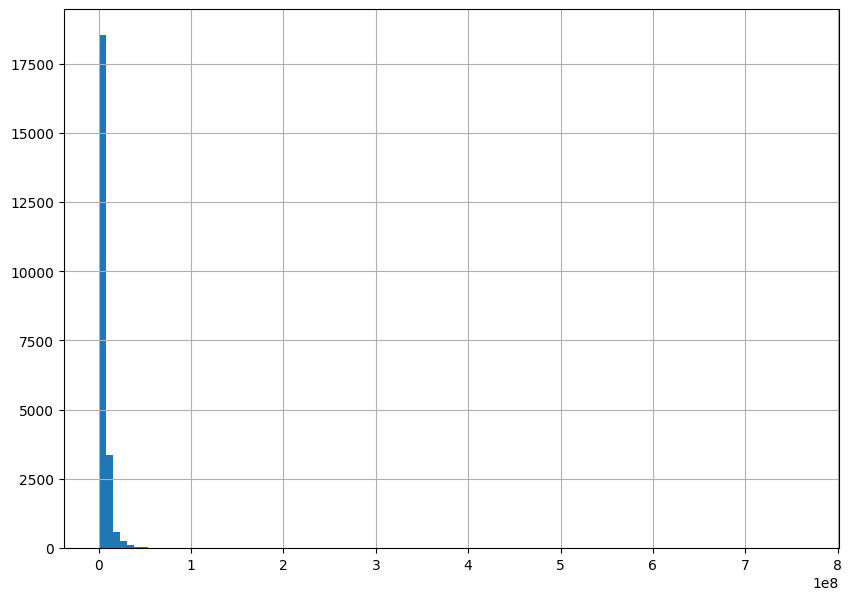

In [280]:
data['last_price'].hist(bins=100, figsize=(10, 7))

На гистограмме этого четко не видно, но здесь есть сильно отклоняющиеся значения, т.к. при не заданном `range` область графика сильно смещена вправо.

In [281]:
data.sort_values(by='last_price', ascending=False)

total_images   last_price  total_area first_day_exposition  rooms  \
12629            19  763000000.0       400.0           2017-09-30      7   
18994             8  420000000.0       900.0           2017-12-06     12   
14303            15  401300000.0       401.0           2016-02-20      5   
1395             19  330000000.0       190.0           2018-04-04      3   
15224            20  300000000.0       618.0           2017-12-18      7   
...             ...          ...         ...                  ...    ...   
5558              7     450000.0        42.0           2017-07-31      2   
15838            18     440000.0        40.0           2018-07-10      1   
16971             7     430000.0        30.4           2019-04-22      1   
14500             5     430000.0        54.0           2018-06-26      2   
8588              7      12190.0       109.0           2019-03-20      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
12629            3.08            10        250.0     10         False  ...   
18994            2.80            25        409.7     25         False  ...   
14303            3.08             9        204.0      9         False  ...   
1395             3.50             7         95.0      5         False  ...   
15224            3.40             7        258.0      5         False  ...   
...               ...           ...          ...    ...           ...  ...   
5558             2.60             1         23.0      1         False  ...   
15838            2.60             5         17.6      1         False  ...   
16971            2.60             2         16.0      1         False  ...   
14500            2.60             3         30.5      3         False  ...   
8588             2.75            25         32.0     25         False  ...   

       balcony                              locality_name  airports_nearest  \
12629        2                            Санкт-Петербург           25108.0   
18994        0                            Санкт-Петербург           30706.0   
14303        3                            Санкт-Петербург           21912.0   
1395         0                            Санкт-Петербург           23011.0   
15224        0                            Санкт-Петербург           32440.0   
...        ...                                        ...               ...   
5558         0                 городской поселок Будогощь               NaN   
15838        0                         деревня Старополье               NaN   
16971        0                                     Сланцы               NaN   
14500        0  поселок при железнодорожной станции Свирь               NaN   
8588         0                            Санкт-Петербург           36421.0   

       city_centers_nearest parks_around_3_km  parks_nearest  \
12629                3956.0                 1          530.0   
18994                7877.0                 0            NaN   
14303                2389.0                 1          545.0   
1395                 1197.0                 3          519.0   
15224                5297.0                 0            NaN   
...                     ...               ...            ...   
5558                    NaN                 0            NaN   
15838                   NaN                 0            NaN   
16971                   NaN                 0            NaN   
14500                   NaN                 0            NaN   
8588                 9176.0                 1          805.0   

       ponds_around_3_km  ponds_nearest  days_exposition  delta  
12629                  3          756.0             33.0   40.0  
18994                  2          318.0            106.0  378.3  
14303                  1          478.0            393.0  173.0  
1395                   3          285.0            233.0   55.0  
15224                  2          198.0            111.0  290.0  
...                  ...            ...    

Сейчас трудно говорить о том, являются ли выбросами такие большие значения стоимости или нет. 

Но можно точно увидеть, что самая дешевая квартира является искажанием данных, скорее всего тут пропущено 000. Отфильтруем квартиры Петербурга и найдем медианную стоимость двухкомнатной квартиры:

In [282]:
data_filter_temp = data.query('rooms == 2 and locality_name == "Санкт-Петербург"')
#фильтруем данные, где 2 комнаты и нас. пункт - Санкт-Петербург
data_filter_temp.pivot_table(index='rooms', values='last_price', aggfunc='median')
#смотрим медианную стоимость двухкомнатной квартиры

last_price
rooms            
2       5602000.0

Действительно, медианная стоимость квартиры с такими параметрами - около 6М рублей. Учитывая, что квартира, которую рассматриваем - большая, можем добавить 000 к стоимости.

In [283]:
data.loc[(data['last_price'] == 12190), 'last_price'] = 12190000 #корректируем цену

In [284]:
data_last_price_all = data.loc[:, ['last_price']] #создаем таблицу по столбцу last_price

#plt.ylim(0, 16000000) #ограничение для boxplot
#data_last_price_all.boxplot() #вывод графика с усами
display(data_last_price_all.describe()) #описание полученных данных

#fig, ax = plt.subplots(figsize = (17,2))
#ax = data_last_price_all[['last_price']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений стоимости')
#ax.set_xlim(0, 16000000);

last_price
count  2.304400e+04
mean   6.523760e+06
std    1.091921e+07
min    4.300000e+05
25%    3.450000e+06
50%    4.630000e+06
75%    6.750000e+06
max    7.630000e+08

Здесь мы еще не делили квартиры на городские и не городские. Из графика видим, что выбросами являются значения более 12М рублей. Но в городе и в селе такие показатели будут разными.

In [285]:
data_last_price_peter = data.query('locality_name == "Санкт-Петербург"') # создаем таблицу для города Петербурга
data_last_price_peter = data_last_price_peter.loc[:, ['last_price']] #оставляем столбец last_price

data_last_price_peter.describe() #описание полученных данных

last_price
count  1.528300e+04
mean   8.030826e+06
std    1.306041e+07
min    1.200000e+06
25%    4.200000e+06
50%    5.500000e+06
75%    8.100000e+06
max    7.630000e+08

In [286]:
data_last_price_not_peter = data.query('locality_name != "Санкт-Петербург"') # создаем таблицу не для города Петербурга
data_last_price_not_peter = data_last_price_not_peter.loc[:, ['last_price']] #оставляем столбец last_price

data_last_price_not_peter.describe() #описание полученных данных

last_price
count  7.761000e+03
mean   3.556038e+06
std    2.201709e+06
min    4.300000e+05
25%    2.370000e+06
50%    3.200000e+06
75%    4.200000e+06
max    4.200000e+07

- для "не Питера" медианные значения - 3.2М;
- для Питера - 5.5М рублей. 

Разница большая, надо разграничить выборки. Добавим столбец с булевыми значениями для обозначения: это Петербург или нет:

In [287]:
def location(x): # Создаем функцию
    for i in data['locality_name']: # которая перебирает каждое значение в столбце 'locality_name'
        if x['locality_name'] == 'Санкт-Петербург': # если значение в столбце удовлетворяет условию
            return True # то возвращаем значение функции True
        return False # иначе False

data['is_peterburg'] = data.apply(location, axis=1)
data

total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00           2019-03-07      3   
1                 7   3350000.0       40.40           2018-12-04      1   
2                10   5196000.0       56.00           2015-08-20      2   
3                 0  64900000.0      159.00           2015-07-24      3   
4                 2  10000000.0      100.00           2018-06-19      2   
...             ...         ...         ...                  ...    ...   
23039             9   9700000.0      133.81           2017-03-21      3   
23040            14   3100000.0       59.00           2018-01-15      3   
23041            18   2500000.0       56.70           2018-02-11      2   
23042            13  11475000.0       76.75           2017-03-28      2   
23043             4   1350000.0       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70            16       51.000      8         False  ...   
1                2.60            11       18.600      1         False  ...   
2                2.64             5       34.300      4         False  ...   
3                2.64            14       45.000      9         False  ...   
4                3.03            14       32.000     13         False  ...   
...               ...           ...          ...    ...           ...  ...   
23039            3.70             5       73.300      3         False  ...   
23040            2.60             5       38.000      4         False  ...   
23041            2.60             3       29.700      1         False  ...   
23042            3.00            17       45.775     12         False  ...   
23043            2.50             5       12.300      1         False  ...   

             locality_name  airports_nearest  city_centers_nearest  \
0          Санкт-Петербург           18863.0               16028.0   
1           поселок Шушары           12817.0               18603.0   
2          Санкт-Петербург           21741.0               13933.0   
3          Санкт-Петербург           28098.0                6800.0   
4          Санкт-Петербург           31856.0                8098.0   
...                    ...               ...                   ...   
23039      Санкт-Петербург           24665.0                4232.0   
23040                Тосно               NaN                   NaN   
23041     село Рождествено               NaN                   NaN   
23042      Санкт-Петербург           39140.0               10364.0   
23043  поселок Новый Учхоз               NaN                   NaN   

       parks_around_3_km parks_nearest  ponds_around_3_km  ponds_nearest  \
0                      1         482.0                  2          755.0   
1                      0           NaN                  0            NaN   
2                      1          90.0                  2          574.0   
3                      2          84.0                  3          234.0   
4                      2         112.0                  1           48.0   
...                  ...           ...                ...            ...   
23039                  1         796.0                  3          381.0   
23040                  0           NaN                  0            NaN   
23041                  0           NaN                  0            NaN   
23042                  2         173.0                  3          196.0   
23043                  0           NaN                  0            NaN   

       days_exposition    delta  is_peterburg  
0                  NaN   32.000          True  
1                 81.0   10.800         False  
2                558.0   13.400          True  
3                424.0  104.400          True  
4                121.0   27.000          True  
...                ...      ...           ...  
23039              NaN   46.680          True  
23040             45.0   12.500

Посмотрим еще раз на гистограмму, найдем редкие значения для Петербурга и других населенных пунктов:

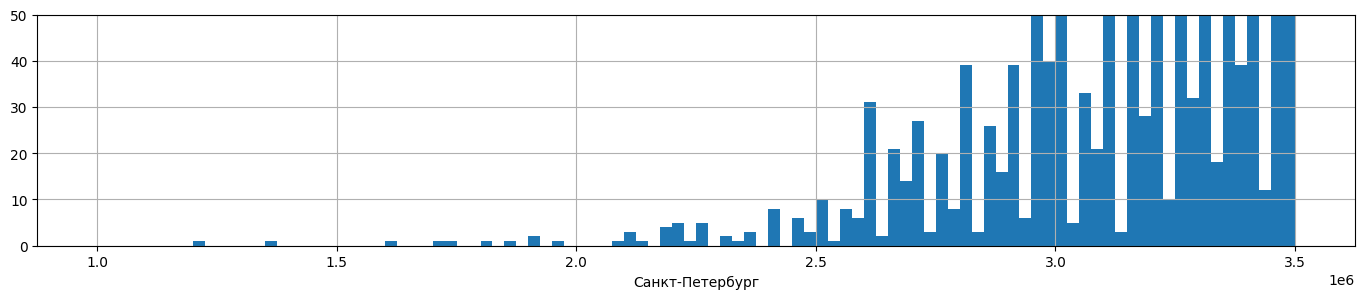

In [288]:
fig, ax = plt.subplots()
plt.ylim(0,50)
ax.set_xlabel('Санкт-Петербург')

data_last_price_peter['last_price'].hist(bins=100, figsize=(17, 3), range = (1000000, 3500000));

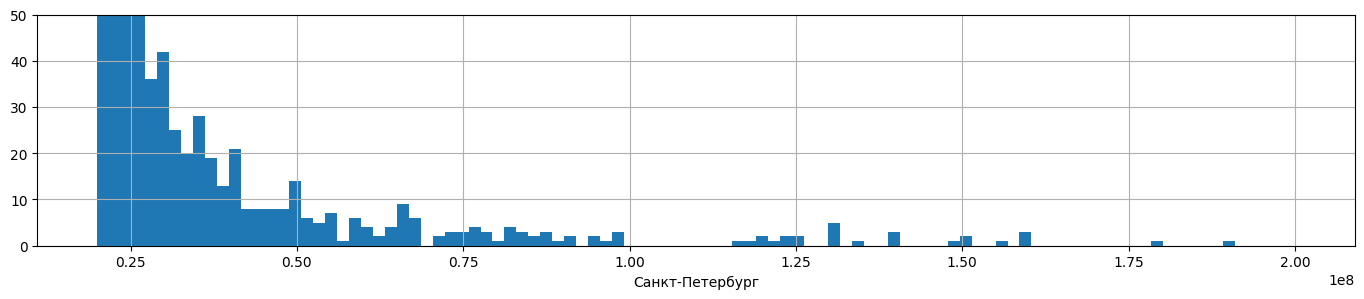

In [289]:
fig, ax = plt.subplots()
plt.ylim(0,50)
ax.set_xlabel('Санкт-Петербург')

data_last_price_peter['last_price'].hist(bins=100, figsize=(17, 3), range = (20000000, 200000000));

Для Санкт-Петербурга являются редкими значения стоимости < 2 000 000 рублей и > 70 000 000 рублей.

Для остальных населенных пунктов:

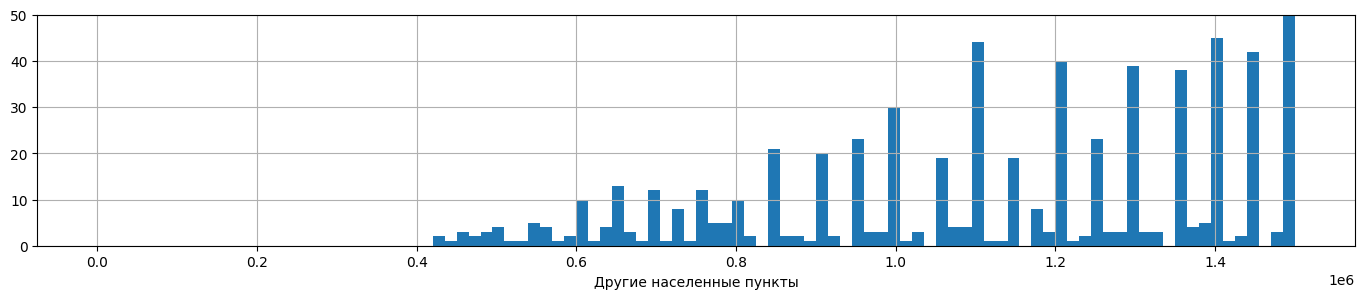

In [290]:
fig, ax = plt.subplots()
plt.ylim(0,50)
ax.set_xlabel('Другие населенные пункты')

data_last_price_not_peter['last_price'].hist(bins=100, figsize=(17, 3), range = (0, 1500000));

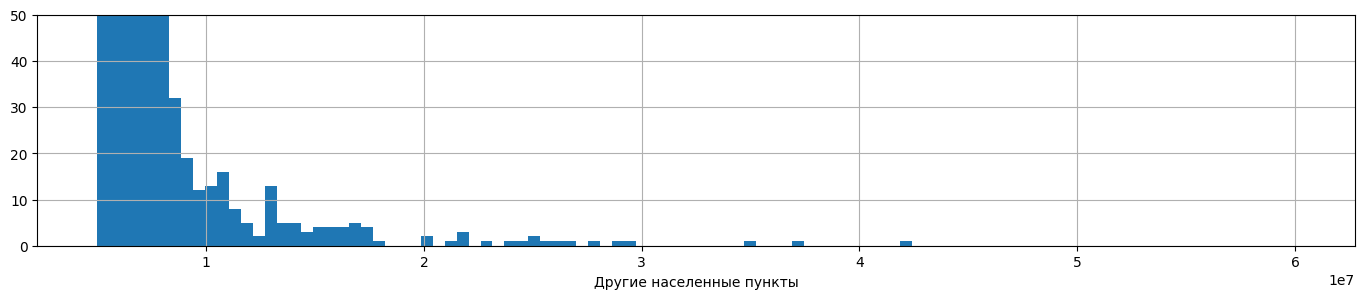

In [291]:
fig, ax = plt.subplots()
plt.ylim(0,50)
ax.set_xlabel('Другие населенные пункты')

data_last_price_not_peter['last_price'].hist(bins=100, figsize=(17, 3), range = (5000000, 60000000));

Для остальных населенных пунктов являются редкими значения стоимости < 600 000 рублей и > 19 000 000 рублей.

Создаем фильтр:

In [292]:
data.shape

(23044, 24)

In [293]:
data = data.query(
    '(last_price >= 2000000 and last_price <= 70000000 and is_peterburg == True) \
    or (last_price >= 600000 and last_price <= 19000000 and is_peterburg == False)'
).reset_index(drop=True)
data.sort_values(by='last_price', ascending=False) #вывод осортированной по 'ratio_price' data

total_images  last_price  total_area first_day_exposition  rooms  \
16310             3  68500000.0       160.0           2016-06-18      4   
19672            20  68000000.0       254.0           2018-06-30      5   
21257            20  68000000.0       373.1           2018-09-08      8   
7222             20  68000000.0       221.0           2017-09-27      5   
20258            14  67000000.0       172.0           2016-05-13      4   
...             ...         ...         ...                  ...    ...   
20812             0    600000.0        43.5           2018-07-02      1   
10873             2    600000.0        45.1           2018-11-09      2   
19755             6    600000.0        42.0           2017-10-13      2   
1799              6    600000.0        30.0           2017-12-19      1   
22184             7    600000.0        31.2           2017-11-16      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
16310            2.64             8         95.4      7         False  ...   
19672            3.46             5        183.6      3         False  ...   
21257            2.64             8        176.2      8         False  ...   
7222             3.08             4        145.0      4         False  ...   
20258            2.64             8        101.0      7         False  ...   
...               ...           ...          ...    ...           ...  ...   
20812            2.50             5         17.6      2         False  ...   
10873            2.50             5         27.9      4         False  ...   
19755            2.60             5         31.0      5         False  ...   
1799             2.60             3         17.0      3         False  ...   
22184            2.80             2         17.6      2         False  ...   

                                    locality_name  airports_nearest  \
16310                             Санкт-Петербург           27102.0   
19672                             Санкт-Петербург           37994.0   
21257                             Санкт-Петербург           37965.0   
7222                              Санкт-Петербург           20779.0   
20258                             Санкт-Петербург           27102.0   
...                                           ...               ...   
20812                городской поселок Никольский               NaN   
10873                           деревня Фалилеево               NaN   
19755                                      Сланцы               NaN   
1799                                       Сланцы               NaN   
22184  поселок при железнодорожной станции Вещево               NaN   

       city_centers_nearest  parks_around_3_km parks_nearest  \
16310                7442.0                  2         164.0   
19672               11154.0                  1         390.0   
21257                7873.0                  1         562.0   
7222                 1253.0                  1         302.0   
20258                7442.0                  2         164.0   
...                     ...                ...           ...   
20812                   NaN                  0           NaN   
10873                   NaN                  0           NaN   
19755                   NaN                  0           NaN   
1799                    NaN                  0           NaN   
22184                   NaN                  0           NaN   

       ponds_around_3_km  ponds_nearest  days_exposition  delta  is_peterburg  
16310                  2          473.0            531.0   42.6          True  
19672                  1          782.0            284.0   25.4          True  
21257                  3          691.0            234.0  167.5          True  
7222                   3           29.0             73.0   66.0          True  
20258                  2          473.0            790.0   54.0          True  
...                  ...            ...              ...    ...    

In [294]:
data.shape

(22912, 24)

##### Обработка площадей `kitchen_area` .

На этапе заполнения пропусков удалось скорректировать некоторые данные по `kitchen_area` и `living_area`.

Осталось проверить эти площади на аномалии. Также сделаем расчет для Петербурга и других населенных пунктов. Студии из оценки площади кухни исключим.

In [295]:
kitchen_peter = data.loc[(data['is_peterburg'] == True) & (data['studio'] == False)] #фильтр - кухни квартир Петербурга
kitchen_peter = kitchen_peter.loc[:, ['kitchen_area']] 

display(kitchen_peter.describe()) #описание полученных данных

kitchen_area
count  15091.000000
mean      10.999120
std        6.062638
min       -8.570000
25%        7.400000
50%        9.600000
75%       12.300000
max      100.900000

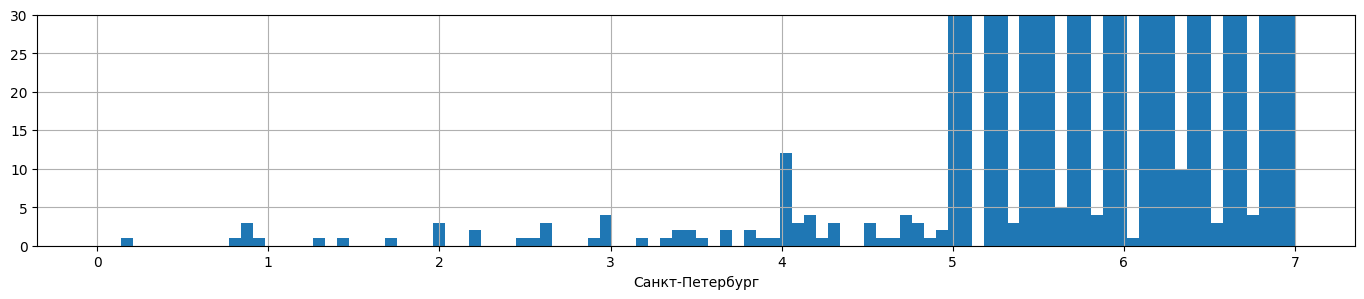

In [296]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Санкт-Петербург')

kitchen_peter['kitchen_area'].hist(bins=100, figsize=(17, 3), range = (0, 7));

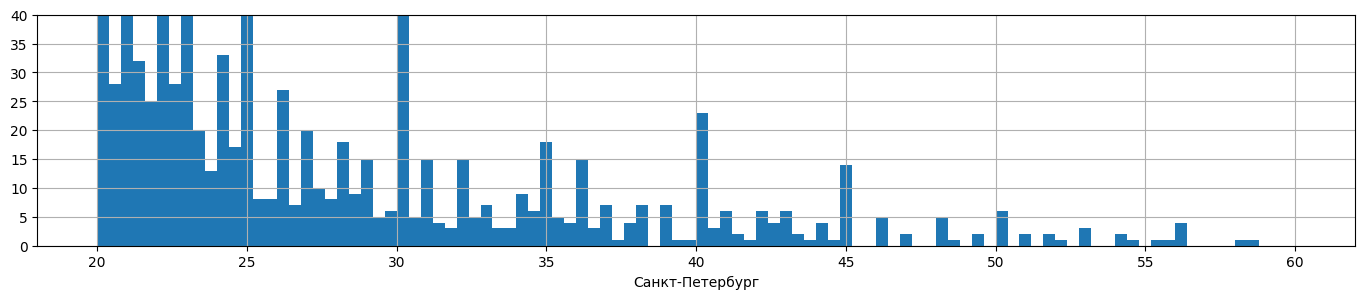

In [297]:
fig, ax = plt.subplots()
plt.ylim(0,40)
ax.set_xlabel('Санкт-Петербург')

kitchen_peter['kitchen_area'].hist(bins=100, figsize=(17, 3), range = (20, 60));

Кухни менее 4.8 метров (кроме студий = 0 кв. метров) и более 41 кв. метра - редкости для Петербурга.

In [298]:
kitchen_not_peter = data.loc[(data['is_peterburg'] == False) & (data['studio'] == False)] #кухни квартир не Петербурга
kitchen_not_peter = kitchen_not_peter.loc[:, ['kitchen_area']] 

display(kitchen_not_peter.describe()) #описание полученных данных

kitchen_area
count   7621.000000
mean       9.364035
std        3.842690
min       -2.330000
25%        7.000000
50%        9.000000
75%       10.700000
max       64.000000

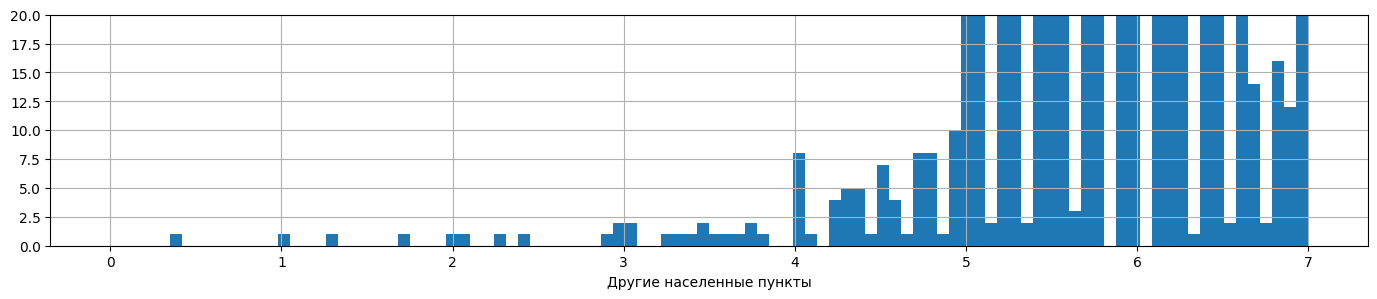

In [299]:
fig, ax = plt.subplots()
plt.ylim(0,20)
ax.set_xlabel('Другие населенные пункты')

kitchen_not_peter['kitchen_area'].hist(bins=100, figsize=(17, 3), range = (0, 7));

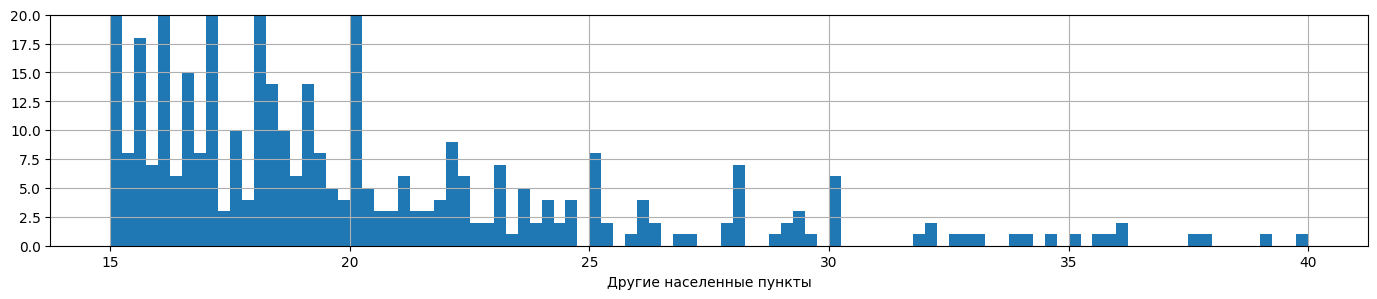

In [300]:
fig, ax = plt.subplots()
plt.ylim(0,20)
ax.set_xlabel('Другие населенные пункты')

kitchen_not_peter['kitchen_area'].hist(bins=100, figsize=(17, 3), range = (15, 40));

Кухни менее 3.9 метров (кроме студий = 0 кв. метров) и более 26 кв. метра - редкости для остальных населенных пунктов.

In [301]:
#kitchen = data.loc[data['studio'] == False]
#kitchen = kitchen.loc[:, ['kitchen_area']] 

#fig, ax = plt.subplots(figsize = (17,2))
#ax = kitchen[['kitchen_area']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений площадей кухонь')
#ax.set_xlim(0, 25);

Напишем фильтр для отбора площадей кухни без аномалий.

In [302]:
data.shape

(22912, 24)

In [303]:
data = data.query(
    '((kitchen_area < 41) and (kitchen_area > 4.8) and (is_peterburg == True)) \
    or ((kitchen_area < 26) and (kitchen_area > 3.9) and (is_peterburg == False)) \
    or (studio == True)').reset_index(drop=True)

In [304]:
# check
data.shape

(22656, 24)

##### Обработка площадей `living_area`

In [305]:
living_peter = data.loc[data['is_peterburg'] == True] 
living_peter = living_peter.loc[:, ['living_area']] 
#фильтр - жилая полощадь квартир Петербурга
display(living_peter.describe()) #описание полученных данных

#fig, ax = plt.subplots(figsize = (17,2))
#ax = living_peter[['living_area']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений площадей жилой зоны Петербурга')
#ax.set_xlim(0, 100);

living_area
count  15025.000000
mean      36.035752
std       22.071795
min        2.000000
25%       19.300000
50%       31.000000
75%       44.000000
max      362.732000

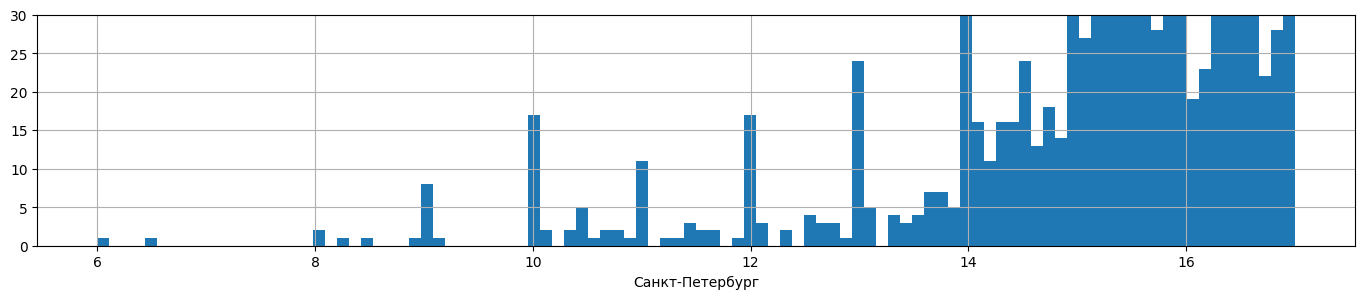

In [306]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Санкт-Петербург')

living_peter['living_area'].hist(bins=100, figsize=(17, 3), range = (6, 17));

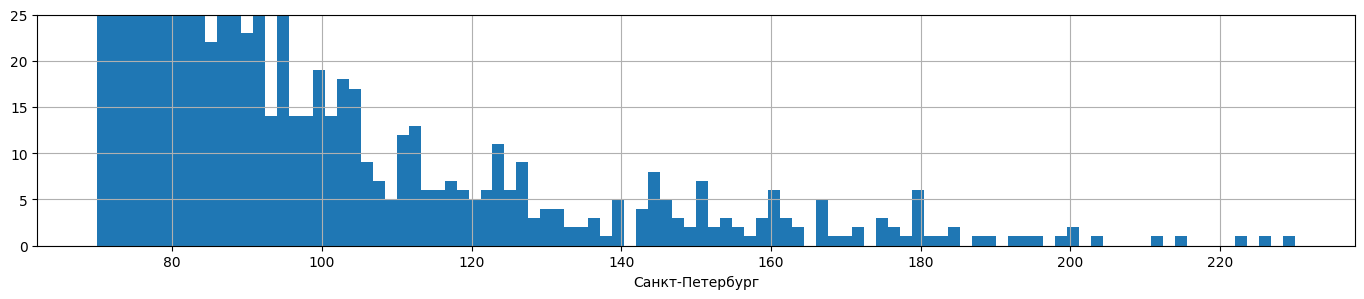

In [307]:
fig, ax = plt.subplots()
plt.ylim(0,25)
ax.set_xlabel('Санкт-Петербург')

living_peter['living_area'].hist(bins=100, figsize=(17, 3), range = (70, 230));

Жилая зона менее 11.5 метров и более 185 кв. метра - редкости для Петербурга.

In [308]:
living_not_peter = data.loc[data['is_peterburg'] == False]
living_not_peter = living_not_peter.loc[:, ['living_area']] 
#фильтр - жилая полощадь квартир остальных пунктов

display(living_not_peter.describe()) #описание полученных данных

#fig, ax = plt.subplots(figsize = (17,2))
#ax = living_not_peter[['living_area']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений площадей жилой зоны других населенных пунктов')
#ax.set_xlim(0, 100);

living_area
count  7631.000000
mean     29.214882
std      12.772580
min       2.000000
25%      17.820000
50%      28.500000
75%      37.000000
max     146.100000

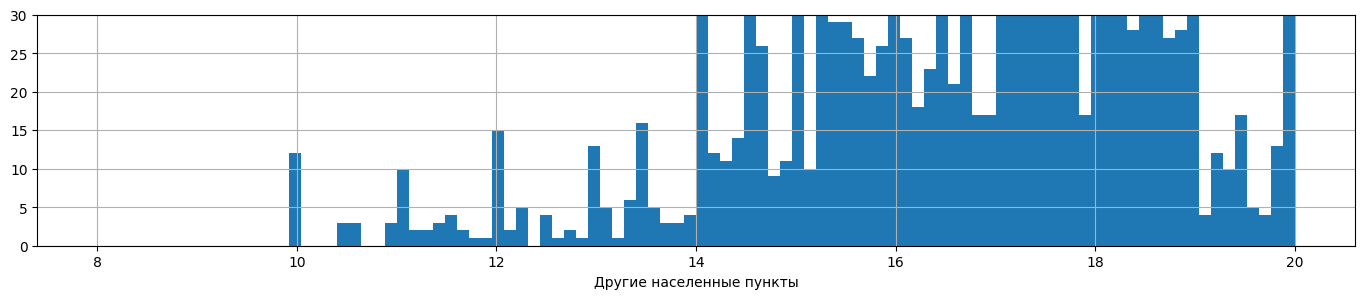

In [309]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Другие населенные пункты')

living_not_peter['living_area'].hist(bins=100, figsize=(17, 3), range = (8, 20));

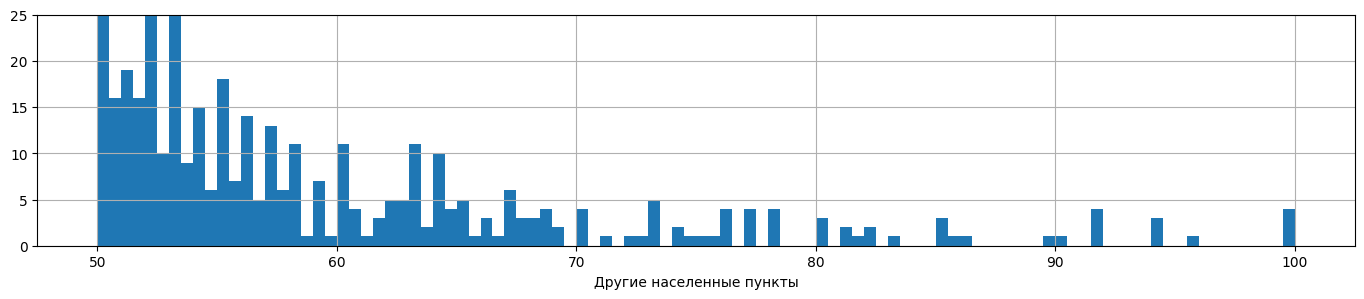

In [310]:
fig, ax = plt.subplots()
plt.ylim(0,25)
ax.set_xlabel('Другие населенные пункты')

living_not_peter['living_area'].hist(bins=100, figsize=(17, 3), range = (50, 100));

Жилая зона менее 11,7 метров и более 88 кв. метра - редкости для остальных населенных пунктов.

Напишем фильтр для отбора жилой площади без аномалий.

In [311]:
data = data.query(
    '((living_area < 185) and (living_area > 11.7) and (is_peterburg == True)) \
    or ((living_area < 88) and (living_area > 11.7) and (is_peterburg == False))').reset_index(drop=True)

In [312]:
# check
data.shape

(22499, 24)

##### `total_area`

В большом городе и в маленькой деревне площадь квартир может отличаться, следовательно, рассмотрим данные, также поделив их на Петербург и другие населенные пункты. Для начала посмотрим общую информацию по всем пунктам:

In [313]:
data_total_area_peter = data.loc[data['is_peterburg'] == True]
data_total_area_peter = data_total_area_peter.loc[:, ['total_area']] #создаем таблицу по столбцу total_area с новой data

#plt.ylim(-10, 150) #ограничение для boxplot
#data_total_area_all1.boxplot() #вывод графика с усами

display(data_total_area_peter.describe()) #описание полученных данных

#fig, ax = plt.subplots(figsize = (17,2))
#ax = data_total_area_peter[['total_area']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений общей площади для Петербурга')
#ax.set_xlim(-10, 150);

total_area
count  14931.000000
mean      62.813991
std       32.898923
min       16.000000
25%       42.000000
50%       55.000000
75%       73.865000
max      494.100000

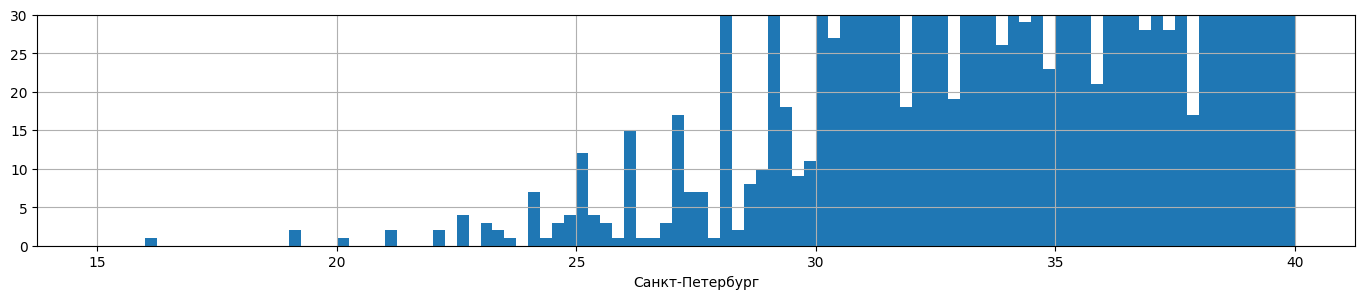

In [314]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Санкт-Петербург')

data_total_area_peter['total_area'].hist(bins=100, figsize=(17, 3), range = (15, 40));

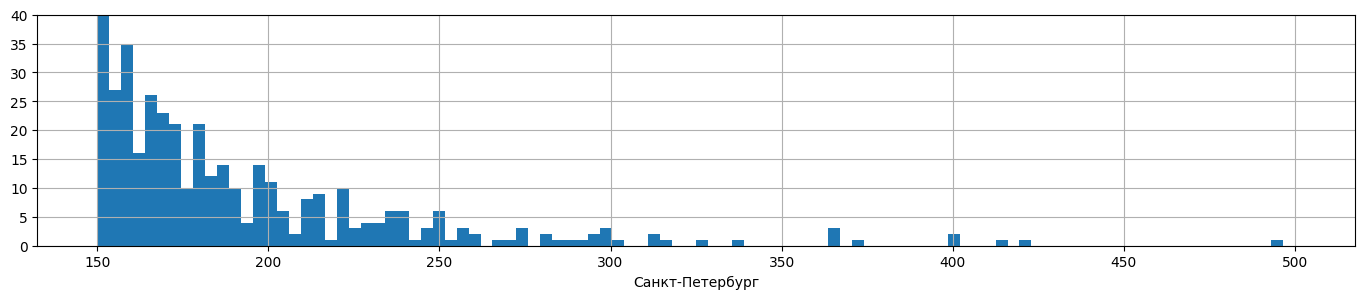

In [315]:
fig, ax = plt.subplots()
plt.ylim(0,40)
ax.set_xlabel('Санкт-Петербург')

data_total_area_peter['total_area'].hist(bins=100, figsize=(17, 3), range = (150, 500));

Для Петербурга редкими являются значения менее 23 кв. метров и более 250 кв. метров.

Для остальных населенных пунктов.

In [316]:
data_total_area_not_peter = data.loc[data['is_peterburg'] == False]
data_total_area_not_peter = data_total_area_not_peter.loc[:, ['total_area']] #создаем таблицу по столбцу total_area с новой data

#plt.ylim(-10, 150) #ограничение для boxplot
#data_total_area_all1.boxplot() #вывод графика с усами

display(data_total_area_not_peter.describe()) #описание полученных данных

#fig, ax = plt.subplots(figsize = (17,2))
#ax = data_total_area_not_peter[['total_area']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений общей площади кроме Петербурга')
#ax.set_xlim(-10, 150);

total_area
count  7568.000000
mean     51.003798
std      17.657000
min      17.000000
25%      37.000000
50%      47.000000
75%      60.600000
max     236.000000

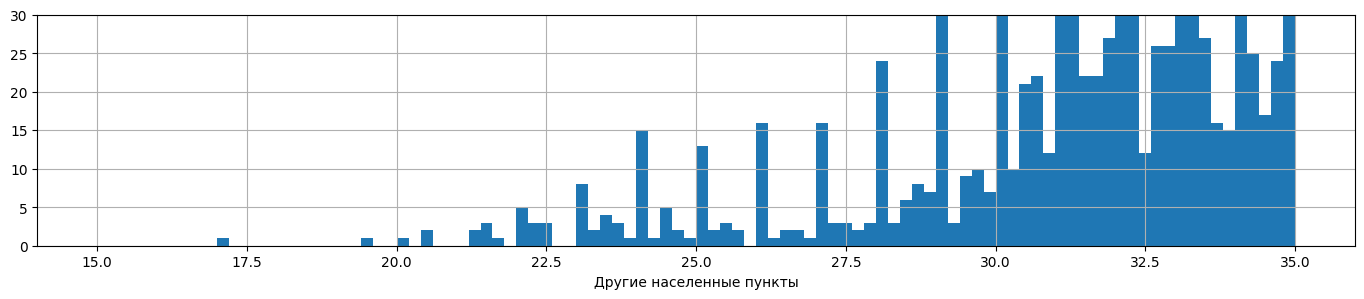

In [317]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Другие населенные пункты')

data_total_area_not_peter['total_area'].hist(bins=100, figsize=(17, 3), range = (15, 35));

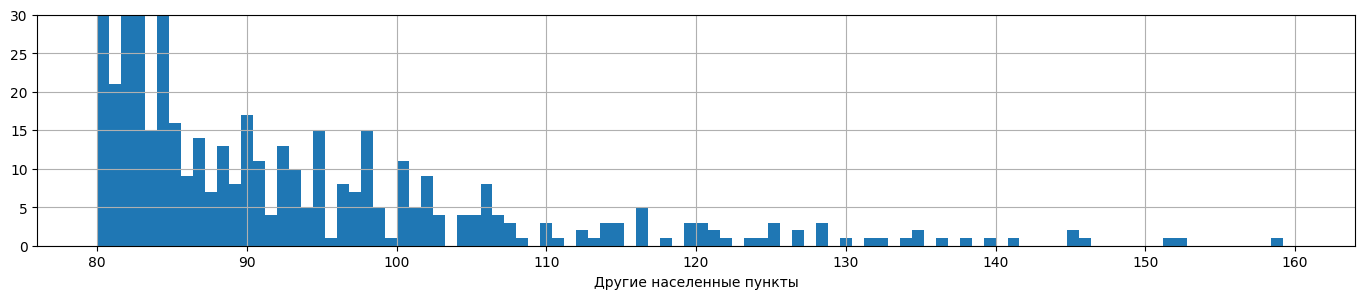

In [318]:
fig, ax = plt.subplots()
plt.ylim(0,30)
ax.set_xlabel('Другие населенные пункты')

data_total_area_not_peter['total_area'].hist(bins=100, figsize=(17, 3), range = (80, 160));

Для остальных населенных пунктов диапазон значений общей площади будет от 21 кв. метра до 150 кв. метров.

Настроим фильтр.

In [319]:
data = data.query(
    '(total_area >= 23 and total_area <= 250 and is_peterburg == True) \
    or (total_area >= 21 and total_area <= 150 and is_peterburg == False)'
).reset_index(drop=True)
data.sort_values(by='total_area', ascending=False) #вывод осортированной по 'ratio_price' data

total_images  last_price  total_area first_day_exposition  rooms  \
13189            13  14300000.0      250.00           2018-04-04      5   
19678             0  24000000.0      250.00           2019-04-23      9   
12333             0  22250000.0      249.90           2019-04-23      9   
7340             20  16000000.0      248.00           2017-07-25      7   
7148             16  43500000.0      245.80           2015-12-17      3   
...             ...         ...         ...                  ...    ...   
20804             6   2000000.0       21.57           2018-04-19      1   
12071             9   1800000.0       21.40           2018-07-21      1   
3689             13   1700000.0       21.40           2015-02-11      0   
8927              9   1900000.0       21.30           2018-01-15      1   
7857             11   2300000.0       21.30           2018-03-16      0   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
13189            2.50            17       119.00     16         False  ...   
19678            3.20             5       160.60      3         False  ...   
12333            3.20             5       157.00      5         False  ...   
7340             3.32             6       166.70      2         False  ...   
7148             4.45             7       170.80      7          True  ...   
...               ...           ...          ...    ...           ...  ...   
20804            2.60            19        15.10     13         False  ...   
12071            2.60            18        13.00      6         False  ...   
3689             2.70             3        18.00      2         False  ...   
8927             2.70            19        14.92     16         False  ...   
7857             2.60            22        18.00      1         False  ...   

         locality_name  airports_nearest  city_centers_nearest  \
13189  Санкт-Петербург           39441.0               11144.0   
19678  Санкт-Петербург           10328.0                9987.0   
12333  Санкт-Петербург           10328.0                9987.0   
7340   Санкт-Петербург           20074.0                3147.0   
7148   Санкт-Петербург               NaN                5735.0   
...                ...               ...                   ...   
20804           Мурино               NaN                   NaN   
12071       Никольское               NaN                   NaN   
3689        Всеволожск               NaN                   NaN   
8927            Мурино               NaN                   NaN   
7857            Мурино               NaN                   NaN   

       parks_around_3_km parks_nearest  ponds_around_3_km  ponds_nearest  \
13189                  0           NaN                  0            NaN   
19678                  2         352.0                  0            NaN   
12333                  2         352.0                  0            NaN   
7340                   2         575.0                  3           56.0   
7148                   2         110.0                  0            NaN   
...                  ...           ...                ...            ...   
20804                  0           NaN                  0            NaN   
12071                  0           NaN                  0            NaN   
3689                   0           NaN                  0            NaN   
8927                   0           NaN                  0            NaN   
7857                   0           NaN                  0            NaN   

       days_exposition    delta  is_peterburg  
13189            222.0  110.000          True  
19678              NaN   77.700          True  
12333              NaN   80.500          True  
7340               9.0   56.000          True  
7148            1067.0   50.000          True  
...                ...      ...           ...  
20804            144.0    2.157         False  
12071             40.0    2.140         False  
3689               NaN    3.400

In [320]:
data.shape

(22438, 24)

##### `first_day_exposition`

<AxesSubplot:>

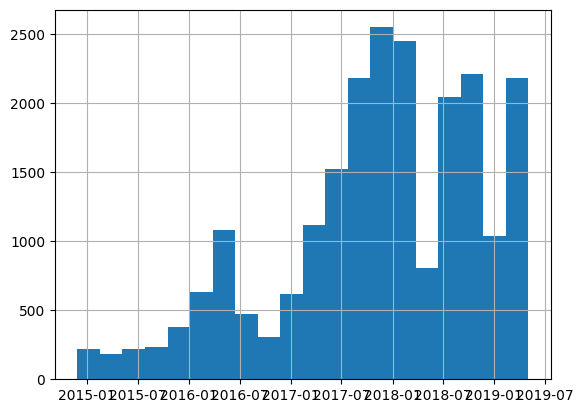

In [321]:
data['first_day_exposition'].hist(bins=20)

Здесь нет каких-либо значимых аномалий. В какие-то дни больше объявлений, в какие-то меньше.

##### `ceiling_height`

<AxesSubplot:>

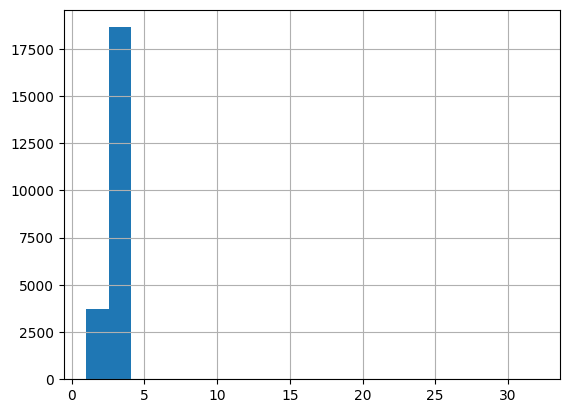

In [322]:
data['ceiling_height'].hist(bins=20)

Есть сдвиг. Изучим данные.

In [323]:
data['ceiling_height'].describe()

count    22411.000000
mean         2.720837
std          0.745428
min          1.000000
25%          2.600000
50%          2.640000
75%          2.740000
max         32.000000
Name: ceiling_height, dtype: float64

Потолки не могум быть высотой в 1 метр, и вряд ли 32 метра. 

Изучим большие значения.

In [324]:
data.sort_values(by='ceiling_height', ascending=False).head(10) #вывод осортированной по 'ratio_price' data

total_images  last_price  total_area first_day_exposition  rooms  \
21139            19   9999000.0        92.4           2019-04-05      2   
2992             14   2900000.0        75.0           2018-11-12      3   
21707            14   4000000.0        98.0           2018-03-15      4   
16899             1   3900000.0        56.0           2017-12-22      3   
19377            11   8000000.0        45.0           2017-07-18      1   
4990              0   2500000.0        54.0           2017-10-13      2   
4640              7   3000000.0        25.0           2017-09-27      0   
5526             17   8150000.0        80.0           2019-01-09      2   
10224             8   3800000.0        58.0           2017-10-13      2   
5395              4   4400000.0        50.0           2017-08-08      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
21139            32.0             6         55.5      5         False  ...   
2992             32.0             3         53.0      2         False  ...   
21707            27.0             2         73.0      2          True  ...   
16899            27.0             5         33.0      4         False  ...   
19377            27.0             4         22.0      2         False  ...   
4990             27.0             5         30.0      3         False  ...   
4640             27.0            25         17.0     17         False  ...   
5526             27.0            36         41.0     13         False  ...   
10224            27.0            10         30.1      3         False  ...   
5395             26.0             9         21.3      3         False  ...   

         locality_name  airports_nearest  city_centers_nearest  \
21139  Санкт-Петербург           18838.0                3506.0   
2992            Волхов               NaN                   NaN   
21707   деревня Нижняя               NaN                   NaN   
16899  Санкт-Петербург           41030.0               15543.0   
19377  Санкт-Петербург           18975.0                3246.0   
4990      деревня Мины               NaN                   NaN   
4640            Мурино               NaN                   NaN   
5526   Санкт-Петербург           18732.0               20444.0   
10224           Мурино               NaN                   NaN   
5395   Санкт-Петербург           28981.0               10912.0   

       parks_around_3_km parks_nearest  ponds_around_3_km  ponds_nearest  \
21139                  0           NaN                  3          511.0   
2992                   0           NaN                  0            NaN   
21707                  0           NaN                  0            NaN   
16899                  0           NaN                  0            NaN   
19377                  0           NaN                  3          449.0   
4990                   0           NaN                  0            NaN   
4640                   0           NaN                  0            NaN   
5526                   0           NaN                  3           80.0   
10224                  0           NaN                  0            NaN   
5395                   1         305.0                  0            NaN   

       days_exposition  delta  is_peterburg  
21139              NaN   20.4          True  
2992               NaN   14.0         False  
21707             27.0   16.0         False  
16899             73.0    5.6          True  
19377            429.0   13.0          True  
4990             540.0   15.0         False  
4640              28.0    8.0         False  
5526              38.0   27.0          True  
10224             71.0   19.8         False  
5395             267.0   21.7          True  

[10 rows x 24 columns]

Логично предположить, что высота потолка в квартирах со значениями 25 - 32 метра, это недочет в данных. Можно предположить, что заполняющий ошибся с порядком ввода. Исправим этот недочет.

Известно, что стандартный потолок должен иметь высоту от 2.5 метров, и обычно не превышает 4 метра. Сейчас важна первая цифра. Уменьшим на порядок высоту потолка в квартирах, в которых высота более 25 метров:

In [325]:
data.loc[(data['ceiling_height'] >= 25), 'ceiling_height'] = data['ceiling_height'] / 10 
#уменьшаем данные о потолке на порядок

Потолки, высота которых меньше 2.5 метров можно привести к этому значению. Оно будет минимальным.

In [326]:
data.loc[(data['ceiling_height'] <= 2.5), 'ceiling_height'] = 2.5
#указываем минимальное значение

Те значения, что находятся выше 4 метров сделаем медианными.

In [327]:
data.loc[(data['ceiling_height'] > 4), 'ceiling_height'] = data['ceiling_height'].median()
data['ceiling_height'].describe()

count    22411.000000
mean         2.696267
std          0.214379
min          2.500000
25%          2.600000
50%          2.640000
75%          2.730000
max          4.000000
Name: ceiling_height, dtype: float64

##### `floors_total`

<AxesSubplot:>

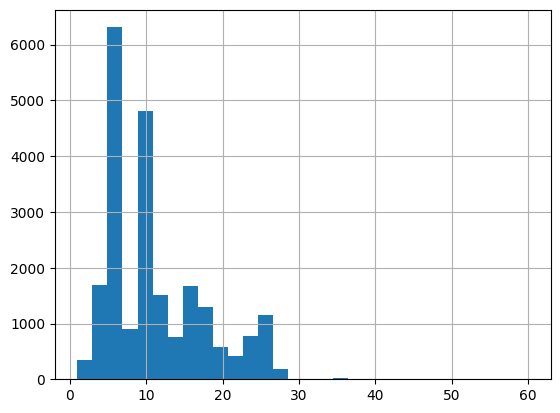

In [328]:
data['floors_total'].hist(bins=30)

Здесь тоже есть выбивающиеся значения

In [329]:
data.sort_values(by='floors_total', ascending=False).head(10) #вывод осортированной по 'ratio_price' data

total_images  last_price  total_area first_day_exposition  rooms  \
2133             12   3800000.0        45.5           2018-06-28      2   
16035             5   4100000.0        40.0           2017-10-17      1   
377              15   5990000.0        54.0           2018-03-22      2   
10516            16   9200000.0        75.0           2019-02-22      2   
5526             17   8150000.0        80.0           2019-01-09      2   
21715            14   7690000.0        75.0           2018-03-27      2   
9099              9   3450000.0        24.8           2019-02-01      0   
8903             12   7390000.0        70.0           2017-02-21      2   
12208             7   7600000.0        70.0           2016-11-18      3   
13584            14   8595000.0        69.7           2018-09-26      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
2133             2.88            60         27.4      4         False  ...   
16035            2.50            37         17.4      5         False  ...   
377              2.64            36         21.4     28         False  ...   
10516            2.70            36         40.0     29         False  ...   
5526             2.70            36         41.0     13         False  ...   
21715            2.64            35         40.0      8         False  ...   
9099             2.68            35         16.0     17         False  ...   
8903             2.70            35         28.0      3         False  ...   
12208            2.70            35         36.5     27         False  ...   
13584            2.64            35         27.4     26         False  ...   

         locality_name  airports_nearest  city_centers_nearest  \
2133         Кронштадт           67763.0               49488.0   
16035  Санкт-Петербург           18732.0               20444.0   
377    Санкт-Петербург           18732.0               20444.0   
10516  Санкт-Петербург           18732.0               20444.0   
5526   Санкт-Петербург           18732.0               20444.0   
21715  Санкт-Петербург           18732.0               20444.0   
9099   Санкт-Петербург           18732.0               20444.0   
8903   Санкт-Петербург           18732.0               20444.0   
12208  Санкт-Петербург           18732.0               20444.0   
13584  Санкт-Петербург           18732.0               20444.0   

       parks_around_3_km parks_nearest  ponds_around_3_km  ponds_nearest  \
2133                   2         342.0                  3          614.0   
16035                  0           NaN                  3           80.0   
377                    0           NaN                  3           80.0   
10516                  0           NaN                  3           80.0   
5526                   0           NaN                  3           80.0   
21715                  0           NaN                  3           80.0   
9099                   0           NaN                  3           80.0   
8903                   0           NaN                  3           80.0   
12208                  0           NaN                  3           80.0   
13584                  0           NaN                  3           80.0   

       days_exposition  delta  is_peterburg  
2133             166.0  10.70         False  
16035             71.0  14.26          True  
377               11.0  13.90          True  
10516              NaN  23.00          True  
5526              38.0  27.00          True  
21715              NaN  20.00          True  
9099              45.0   8.80          True  
8903             236.0  19.00          True  
12208            413.0  10.40          True  
13584              NaN  19.00          True  

[10 rows x 24 columns]

In [330]:
data['floors_total'].describe()

count    22438.000000
mean        10.741644
std          6.574518
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Мы видим, что два здания сильно превышают этажность над остальными.

В этом есть сомнения: во-первых, таких жилих комплексов не так много (если они вообще есть в пригороде, в случае 60-ти этажного здания), во-вторых, почему среди более 20 тысяч объявлений не нашлось промежуточных этажей?

Мы можем либо убрать эти два здания, либо скорректировать данные. Предлагаю второй вариант.

Так как, судя по данным, в 60-ти этажном здании продается квартира на 4 этаже, может снова ошиблись с порядком? Мы исправим это.

Что касается второго случая - 52 этажа и квартира на 18-м. Тут верным считаю приравнять этажность здания к предыдущему, то есть 37 этажей.

In [331]:
data.loc[(data['floors_total'] == 60), 'floors_total'] = data['floors_total'] / 10 
#уменьшаем данные на порядок
data.loc[(data['floors_total'] == 52), 'floors_total'] = 37

##### `rooms`

<AxesSubplot:>

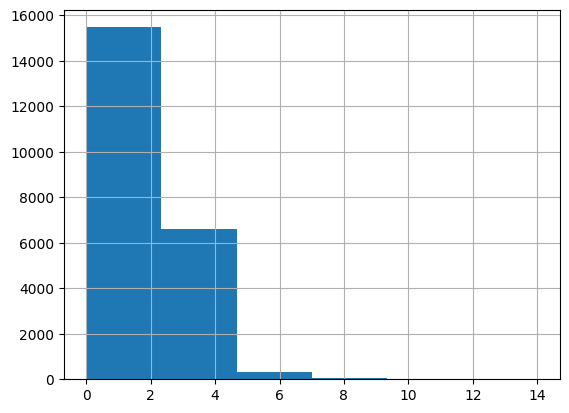

In [332]:
data['rooms'].hist(bins = 6)

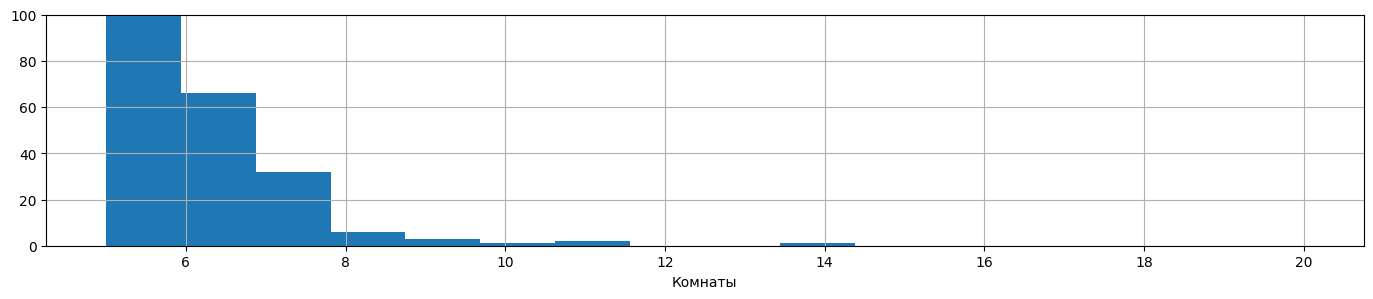

In [333]:
fig, ax = plt.subplots()
plt.ylim(0,100)
ax.set_xlabel('Комнаты')

data['rooms'].hist(bins=16, figsize=(17, 3), range = (5, 20));

Более 6 комнат - радкость

In [334]:
data = data.query('rooms <= 6').reset_index(drop=True)

##### `floor`

Этаж квартиры. Нужно проверить:
- чтобы этаж не был больше этажности дома;
- этаж квартиры не был отрицательным.

In [335]:
data['delta_floor'] = data['floors_total'] - data['floor'] #находим разность между количеством этажей и этажом квартиры
display(data['delta_floor'].min()) #выводим минимальное

0.0

In [336]:
display(data['floor'].min()) #минимальный этаж

1

##### `balcony`, `ponds_around_3_km` и `parks_around_3_km`
 
Также проверим максимальное количество балконов, водоемов и парков:

In [337]:
display(f'Максимальное количество балконов - {data["balcony"].max()}')
display(f'Максимальное количество водоемов в радиусе 3 км - {data["ponds_around_3_km"].max()}')
display(f'Максимальное количество парков в радиусе 3 км - {data["parks_around_3_km"].max()}')

'Максимальное количество балконов - 5'

'Максимальное количество водоемов в радиусе 3 км - 3'

'Максимальное количество парков в радиусе 3 км - 3'

##### `days_exposition`

In [338]:
date_table = data.sort_values(by='days_exposition', ascending=False) 
#сортируем в порядке убывания сводную таблицу по количеству дней
date_table.loc[:, ['first_day_exposition', 'days_exposition']].head() #добавляем фильтр для вывода двух столбцов

first_day_exposition  days_exposition
17805           2014-12-15           1580.0
1039            2014-12-09           1572.0
9054            2014-12-09           1553.0
1778            2014-12-09           1513.0
6341            2014-12-12           1512.0

1580 дней - это немногим больше 4.3 лет.

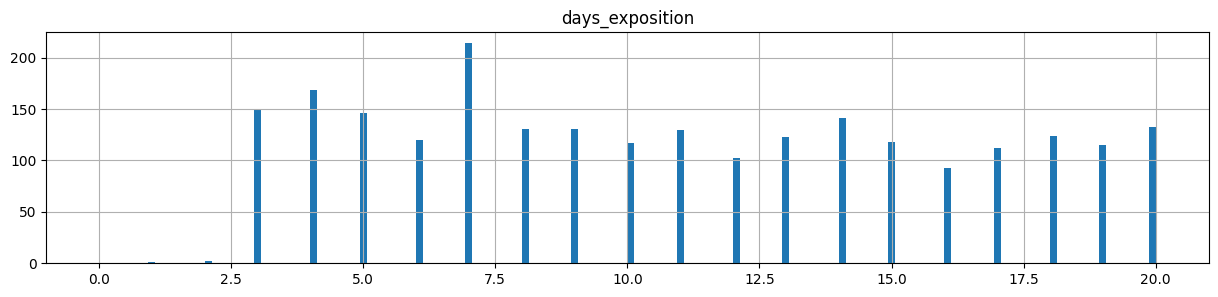

In [339]:
# check
data.hist(column = 'days_exposition', bins = 150, figsize = (15,3), range = (0,20));

1 и 2 дня выглядят выбивающимися значениями.

In [340]:
display(data['days_exposition'].describe())

#fig, ax = plt.subplots(figsize = (17,2))
#ax = data[['days_exposition']].boxplot(vert = False, ax = ax)
#ax.set_title('Диаграмма размаха значений длительности активного объявления')
#ax.set_xlim(-20, 1500);

count    19428.000000
mean       180.306413
std        218.649006
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

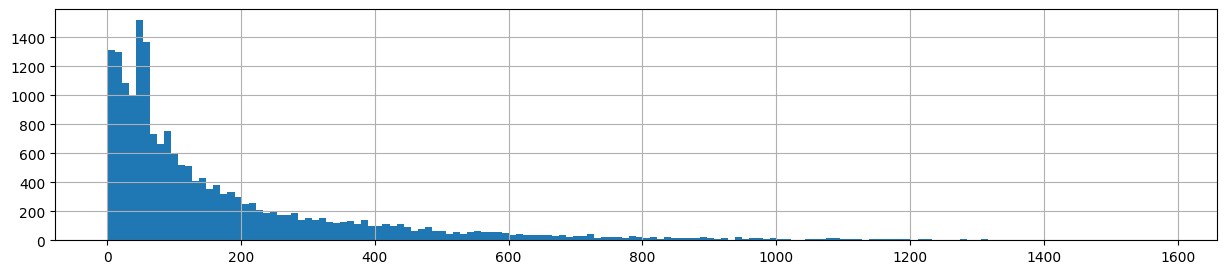

In [341]:
# check
data.days_exposition.hist(bins = 150, figsize = (15,3));

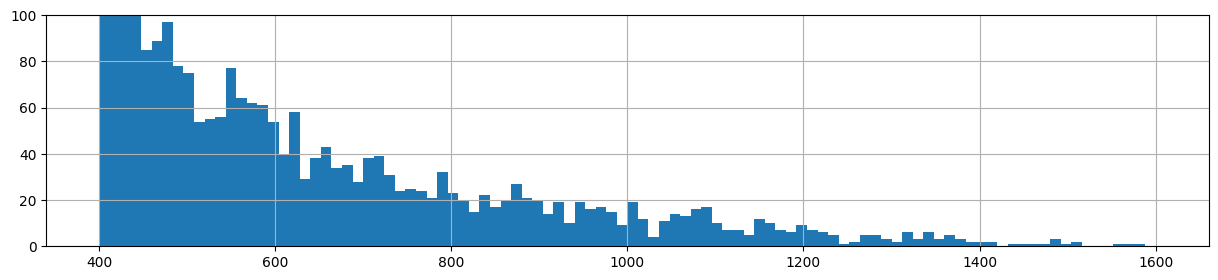

In [342]:
# check
data.days_exposition.hist(bins = 100, figsize = (15,3), range = (400,1600))
plt.ylim(0, 100);

In [343]:
# check
data[data.days_exposition > 1000]['days_exposition'].count()

258

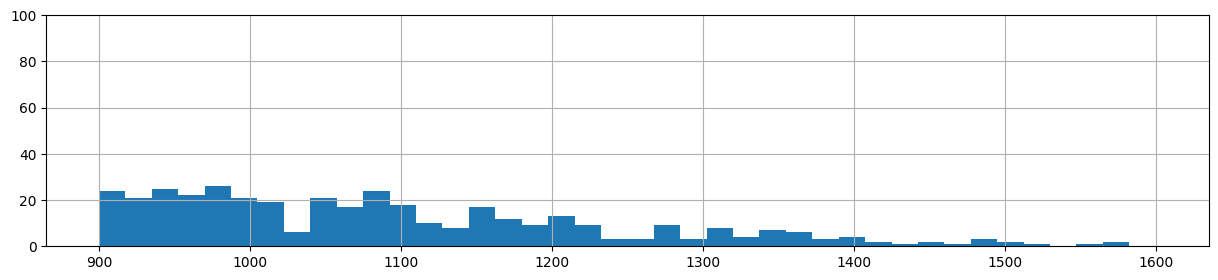

In [344]:
# check
data.days_exposition.hist(bins = 40, figsize = (15,3), range = (900,1600))
plt.ylim(0, 100);

In [345]:
# check
data = data[(data.days_exposition <= 1000) & (data.days_exposition > 2) | (data.days_exposition.isna())].reset_index(drop=True)

In [346]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22132 entries, 0 to 22131
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22132 non-null  int64         
 1   last_price            22132 non-null  float64       
 2   total_area            22132 non-null  float64       
 3   first_day_exposition  22132 non-null  datetime64[ns]
 4   rooms                 22132 non-null  int64         
 5   ceiling_height        22105 non-null  float64       
 6   floors_total          22132 non-null  float64       
 7   living_area           22132 non-null  float64       
 8   floor                 22132 non-null  int64         
 9   is_apartment          22132 non-null  bool          
 10  studio                22132 non-null  bool          
 11  open_plan             22132 non-null  bool          
 12  kitchen_area          22132 non-null  float64       
 13  balcony         

#####  Пропуски в `city_centers_nearest` и `airports_nearest`*

Теперь пора заняться пропусками в расстояниях. Начнем с аэропорта и центра города:

In [347]:
median_airports_nearest_peter = data.query('locality_name == "Санкт-Петербург"') 
# создаем таблицу для города Петербурга
median_airports_nearest_peter = median_airports_nearest_peter['airports_nearest'].median() 
#Вычисляем медианное расстояние до аэропорта

median_city_centers_peter = data.query('locality_name == "Санкт-Петербург"') # создаем таблицу для города Петербурга
median_city_centers_peter = median_city_centers_peter['city_centers_nearest'].median() 
#Вычисляем медианное расстояние до центра

median_airports_nearest_not_peter = data.query('locality_name != "Санкт-Петербург"') 
# создаем таблицу для остальных пунктов
median_airports_nearest_not_peter = median_airports_nearest_not_peter['airports_nearest'].median() 
#Вычисляем медианное расстояние до аэропорта

median_city_centers_not_peter = data.query('locality_name != "Санкт-Петербург"') # создаем таблицу для остальных пунктов
median_city_centers_not_peter = median_city_centers_not_peter['city_centers_nearest'].median() 
#Вычисляем медианное расстояние до центра

data.loc[
    (data['locality_name'] == "Санкт-Петербург") 
    & (data['airports_nearest'].isnull()), 'airports_nearest'] = median_airports_nearest_peter
#если это Петербург И с пустым значением у аэропорта, то присвоим медиану по Петербургу
#остальные строки работают по этому же принципу но с разными условиями

data.loc[
    (data['locality_name'] == "Санкт-Петербург") 
    & (data['city_centers_nearest'].isnull()), 'city_centers_nearest'] = median_city_centers_peter

data.loc[
    (data['locality_name'] != "Санкт-Петербург") 
    & (data['airports_nearest'].isnull()), 'airports_nearest'] = median_airports_nearest_not_peter

data.loc[
    (data['locality_name'] != "Санкт-Петербург") 
    & (data['city_centers_nearest'].isnull()), 'city_centers_nearest'] = median_city_centers_not_peter

##### Пропуски в `parks_around_3_km` и `ponds_around_3_km`*

Для всех строк, в которых заполнена графа `ponds_around_3_km` или `parks_around_3_km` указано расстояние до объектов, причем максимальное его значение действительно не превышает 3000 м.

Для заполнения пропусков можно взять медианные значения по такому принципу: данные делятся на Петербург и другие пункты, медиана берется по каждой группе, по значениям, имеющимся в ячейках с 0 парков и 0 водоемов рядом.

Проверим, есть ли такие данные:

In [348]:
median_parks_nearest_peter = data.query(
    'locality_name == "Санкт-Петербург" and parks_around_3_km == 0') # создаем таблицу для города Петербурга
median_parks_nearest_peter = median_parks_nearest_peter['parks_nearest'].median() 
#Вычисляем медианное расстояние до парков
display(median_parks_nearest_peter)

median_ponds_nearest_peter = data.query(
    'locality_name == "Санкт-Петербург" and ponds_around_3_km == 0') # создаем таблицу для города Петербурга
median_ponds_nearest_peter = median_ponds_nearest_peter['ponds_nearest'].median() 
#Вычисляем медианное расстояние до водоемов
display(median_ponds_nearest_peter)

median_parks_nearest_not_peter = data.query(
    'locality_name != "Санкт-Петербург" and parks_around_3_km == 0') # создаем таблицу для остальных пунктов
median_parks_nearest_not_peter = median_parks_nearest_not_peter['parks_nearest'].median() 
#Вычисляем медианное расстояние до парков
display(median_parks_nearest_not_peter)

median_ponds_nearest_not_peter = data.query(
    'locality_name != "Санкт-Петербург" and ponds_around_3_km == 0') # создаем таблицу для остальных пунктов
median_ponds_nearest_not_peter = median_ponds_nearest_not_peter['ponds_nearest'].median() 
#Вычисляем медианное расстояние до водоемов
display(median_ponds_nearest_not_peter)

3127.0

c:\Users\maxpe\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan

c:\Users\maxpe\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan

c:\Users\maxpe\anaconda3\envs\ds_practicum_env\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan

Мы видим, что для Петербурга есть данные, по которым мы можем посчитать медиану и заполнить пропуски. Для остальных вариантов таких данных нет. Мы не можем заполнить эти данные не исказив их, оставляем их пустыми. Так же мы не будем заполнять медианными значениями столбец `parks_nearest` из-за того, что это исказит данные. Неуказанные данные лучше неправильных.

Незаполненные этажи не помешают решению дальнейших вопросов. 

На этом предобработка данных завершена.

In [349]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

In [350]:
# check
data.rooms.value_counts().to_frame()

rooms
2   7575
1   7558
3   5467
4   1038
5    247
0    182
6     65

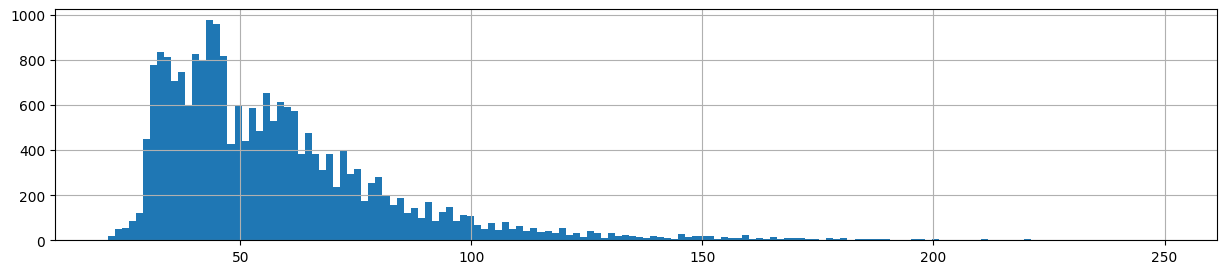

In [351]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

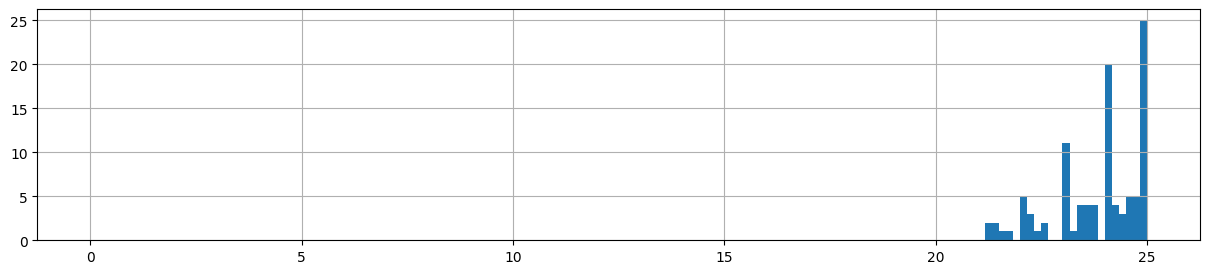

In [352]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (0,25));

Читаем датасет и выводим информацию о ней:

In [353]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

In [354]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

In [355]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир


(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

### Посчитайте и добавьте в таблицу новые столбцы

Добавим новые столбцы в таблицу:
- цена за квадратный метр `ratio_price`;
- день недели публикации `day`;
- месяц публикации `month`;
- год публикации `year`;
- тип этажа квартиры `floor_type` (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах `distance` (перевод из м в км и округление до целых значений). 

*Столбец с ценой одного квадратного метра уже создан и называется `ratio_price`.

In [356]:
data['ratio_price'] = data['last_price'] / data['total_area']
data['day'] = data['first_day_exposition'].dt.weekday 
#из столбца first_day_exposition берем день и присваиваем столбцу день недели

data['month'] = data['first_day_exposition'].dt.month 
#из столбца first_day_exposition берем месяц и присваиваем столбцу месяц

data['year'] = data['first_day_exposition'].dt.year  
#из столбца first_day_exposition берем год и присваиваем столбцу год

Создадим функцию для определения типа этажа.

In [357]:
def types(fl): # Создаем функцию
    for i in data['floor']: # которая перебирает каждое значение в столбце floor
        if fl['floor'] < 1: # если значение в столбце удовлетворяет условию <1
            return 'Цокольный этаж'
        if fl['floor'] == 1: # если значение в столбце удовлетворяет условию ==1
            return 'Первый' # то возвращаем значение функции первый
        if fl['floor'] == fl['floors_total']: #если этаж равен количеству этажей в доме, 
            return 'Последний' #возвращаем последний
        return 'Другой' #для остальных случаев тип этажа - другой

data['floor_type'] = data.apply(types, axis=1) #применяем значение к столбцу

Столбец `distance` - расстояние до центра города в км, округленное до целого значения с преобразованием типа в `int`.

In [358]:
data['distance'] = (data['city_centers_nearest'] / 1000).round().astype('int') 
#вводим столбец расстояния до центра в км, целочисленный
data

total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00           2019-03-07      3   
1                 7   3350000.0       40.40           2018-12-04      1   
2                10   5196000.0       56.00           2015-08-20      2   
3                 0  64900000.0      159.00           2015-07-24      3   
4                10   2890000.0       30.40           2018-09-10      1   
...             ...         ...         ...                  ...    ...   
22127             9   9700000.0      133.81           2017-03-21      3   
22128            14   3100000.0       59.00           2018-01-15      3   
22129            18   2500000.0       56.70           2018-02-11      2   
22130            13  11475000.0       76.75           2017-03-28      2   
22131             4   1350000.0       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70          16.0       51.000      8         False  ...   
1                2.60          11.0       18.600      1         False  ...   
2                2.64           5.0       34.300      4         False  ...   
3                2.64          14.0       45.000      9         False  ...   
4                2.60          12.0       14.400      5         False  ...   
...               ...           ...          ...    ...           ...  ...   
22127            3.70           5.0       73.300      3         False  ...   
22128            2.60           5.0       38.000      4         False  ...   
22129            2.60           3.0       29.700      1         False  ...   
22130            3.00          17.0       45.775     12         False  ...   
22131            2.50           5.0       12.300      1         False  ...   

       days_exposition    delta  is_peterburg  delta_floor    ratio_price  \
0                  NaN   32.000          True          8.0  120370.370370   
1                 81.0   10.800         False         10.0   82920.792079   
2                558.0   13.400          True          1.0   92785.714286   
3                424.0  104.400          True          5.0  408176.100629   
4                 55.0    6.900         False          7.0   95065.789474   
...                ...      ...           ...          ...            ...   
22127              NaN   46.680          True          2.0   72490.845228   
22128             45.0   12.500         False          1.0   52542.372881   
22129              NaN    5.670         False          2.0   44091.710758   
22130            602.0    7.675          True          5.0  149511.400651   
22131              NaN   11.000         False          4.0   41795.665635   

       day  month  year  floor_type  distance  
0        3      3  2019      Другой        16  
1        1     12  2018      Первый        19  
2        3      8  2015      Другой        14  
3        4      7  2015      Другой         7  
4        0      9  2018      Другой        30  
...    ...    ...   ...         ...       ...  
22127    1      3  2017      Другой         4  
22128    0      1  2018      Другой        30  
22129    6      2  2018      Первый        30  
22130    1      3  2017      Другой        10  
22131    4      7  2017      Первый        30  

[22132 rows x 31 columns]

### Проведите исследовательский анализ данных

#### Общая информация. Гистограммы.

Анализируем обработанные данные. Изучим данные по жилой площади.

count    22132.000000
mean        57.980178
std         26.307752
min         21.300000
25%         40.000000
50%         51.680000
75%         68.000000
max        250.000000
Name: total_area, dtype: float64

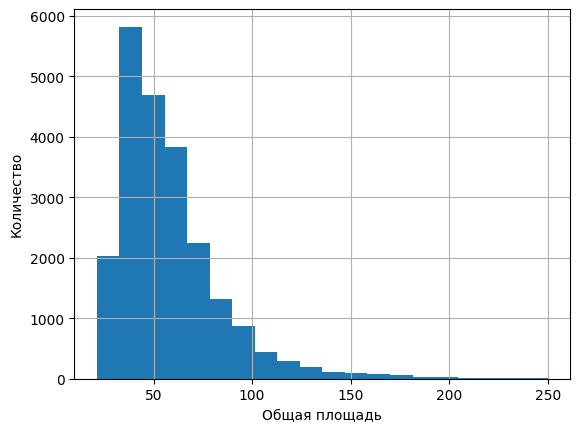

In [359]:
fig, ax = plt.subplots()
ax.set_xlabel('Общая площадь')
ax.set_ylabel('Количество')

data['total_area'].hist(bins=20) #строим гистограмму по столбцу `total_area` с количеством корзин (делений) равным 10
display(data['total_area'].describe()) #описание столбца: мин, макс. значения, медиана (50%) и среднее значение.
#далее код будут повторяться, для других столбцов с разным количеством корзин

Распределение общей площади квартир похоже на распределение Пуассона с некоторой просадкой в районе 50 - 55 кв. метров. Нельзя сказать, что здесь есть выбросы данных, но также нельзя сказать, что данные идеально ложатся в распределение.

- Медианная общая площадь равна 51.68 кв. метрам;
- Максимальная 250 кв. метров;
- Минимальная 21.3 кв. метра.

Максимальная и минимальная общие площади ограничены условиями при предобработке данных. 

count    22132.000000
mean        33.159444
std         17.293699
min         11.790000
25%         18.500000
50%         30.000000
75%         42.000000
max        184.000000
Name: living_area, dtype: float64

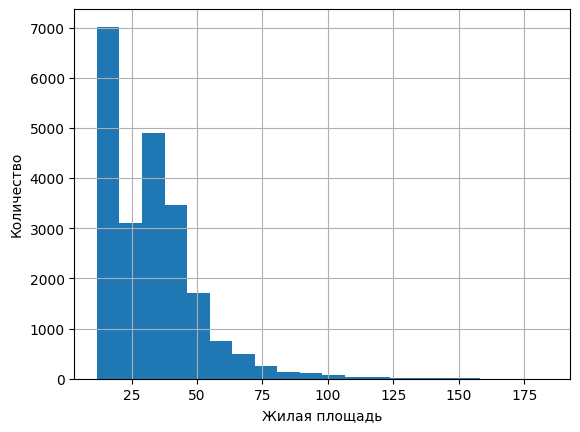

In [360]:
fig, ax = plt.subplots()
ax.set_xlabel('Жилая площадь')
ax.set_ylabel('Количество')

data['living_area'].hist(bins=20)
display(data['living_area'].describe())

Здесь мы видим четко два пика данных, и никакого намека на нормальное распределение (или распределение Пуассона).

- Медианная общая площадь равна 30 кв. метрам;
- Максимальная 184 кв. метров;
- Минимальная 11.79 кв. метров.

Максимальная и минимальная площади ограничены условиями при предобработке данных. Видим, что медианное и среднее значения практически равны. Значит явных выбросов тут нет. 

Первый пик - это очевидно результат того, что в студиях бОльшая часть площади - это жилая зона, в отличие от квартир. В то же время в квартирах с большей общей площадью жилая площадь остается на том же уровне, что и у студий. Этим объясняется и то, почему в гистограмме общей площади нет такой "дыры" после первого пика (площадь кухни ее заполняет).

count    22132.000000
mean        10.079433
std          4.568526
min          0.000000
25%          7.097500
50%          9.000000
75%         11.422500
max         40.700000
Name: kitchen_area, dtype: float64

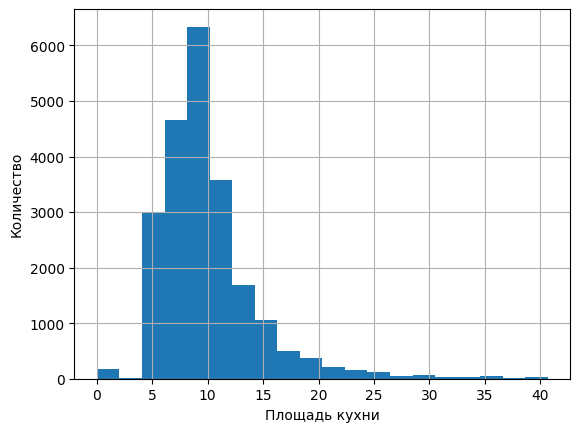

In [361]:
fig, ax = plt.subplots()
ax.set_xlabel('Площадь кухни')
ax.set_ylabel('Количество')

data['kitchen_area'].hist(bins=20)
display(data['kitchen_area'].describe())

Аналогично обстоят дела с площадями кухонь. Только здесь важное напоминание: для студий мы считали площадь кухни нулевой, для квартир - фильтровали данные с помощью ящика с усами. Таким образом, распределение кухонь хорошо ложится в распределение Пуассона с придатком из студий без отдельной кухни.

- Медианная общая площадь равна 9 кв. метрам, что почти совпадает со средним значением;
- Максимальная 40.7 кв. метра - это ограничение предобработки данных;
- Минимальная 0 кв. метров, такие параметры для кухонь в студиях.

count    2.213200e+04
mean     5.885322e+06
std      4.944174e+06
min      6.000000e+05
25%      3.428000e+06
50%      4.600000e+06
75%      6.600000e+06
max      6.850000e+07
Name: last_price, dtype: float64

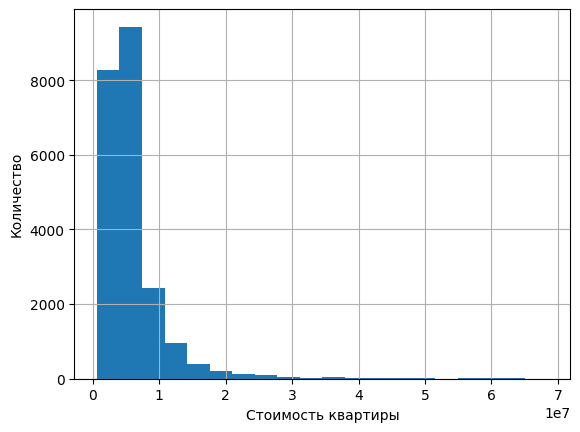

In [362]:
fig, ax = plt.subplots()
ax.set_xlabel('Стоимость квартиры')
ax.set_ylabel('Количество')

data['last_price'].hist(bins=20)
display(data['last_price'].describe())

Обработанные данные по цене - идеальный пример нормального распределения.

- Медианная стоимость квартиры равна 4 600 000 рублей;
- Максимальная 68 500 000 рублей - это ограничение предобработки данных;
- Минимальная 600 000 рублей - это тоже ограничение предобработки данных.

<AxesSubplot:xlabel='Количество комнат', ylabel='Количество'>

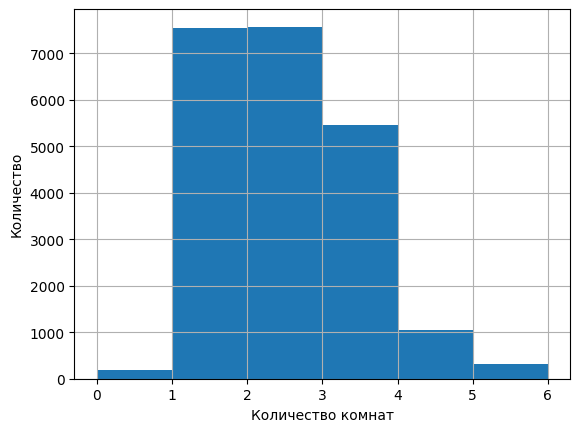

In [363]:
fig, ax = plt.subplots()
ax.set_xlabel('Количество комнат')
ax.set_ylabel('Количество')

data['rooms'].hist(bins=6)

Количество комнат - распределение Пуассона. После обработки данных из датасета ушли слишком большие/многокомнатные квартиры. Данные без них могут быть неполны, но такие данные лишены аномалий.

Больше всего однушек и двушек. Студий, к примеру, не очень много.

<AxesSubplot:xlabel='Высота потолка', ylabel='Количество'>

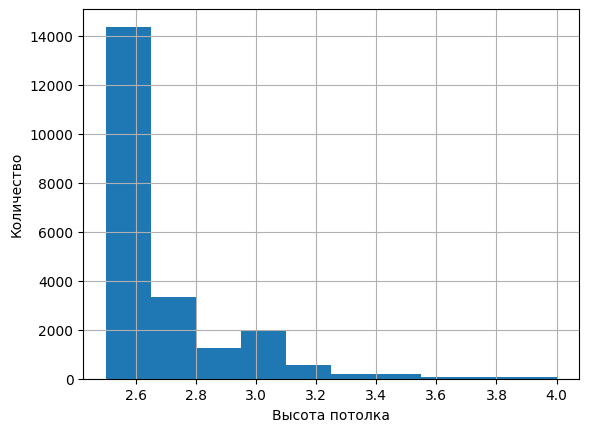

In [364]:
fig, ax = plt.subplots()
ax.set_xlabel('Высота потолка')
ax.set_ylabel('Количество')

data['ceiling_height'].hist(bins=10)

Здесь в данных имеется смещение, но при обработке высоты потолка мы ссылались на нормы, в которых стандартный диапазон высоты - 2.5 - 4 метра. Следовательно, это не является искажением или аномалией.

Почти все значения приходятся на медианные (или средние, здесь они равны) и составляет 2.65 метра.

2    3123
3    2869
1    2684
Name: floor, dtype: int64

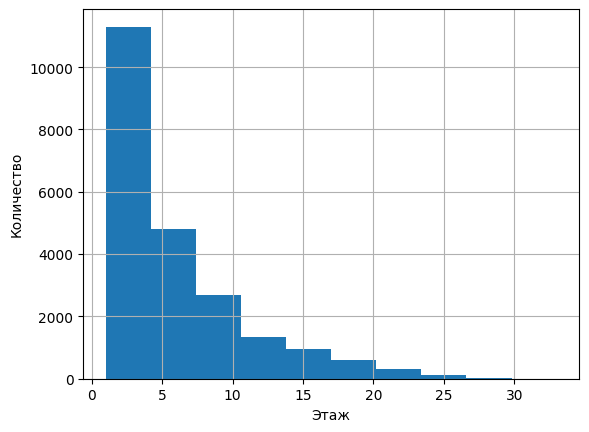

In [365]:
fig, ax = plt.subplots()
ax.set_xlabel('Этаж')
ax.set_ylabel('Количество')

data['floor'].hist(bins=10)
display(data['floor'].value_counts().head(3)) #смотрим наиболее популярные этажи в объявлениях

Распределение продаваемых квартир по этажам. Невысоких домов всегда больше, чем высоких, а следовательно, и объявлений по ним.

Самые частовстречающиеся этажи - 2, 3 и 1 в таком порядке.

<AxesSubplot:xlabel='Тип этажа', ylabel='Количество'>

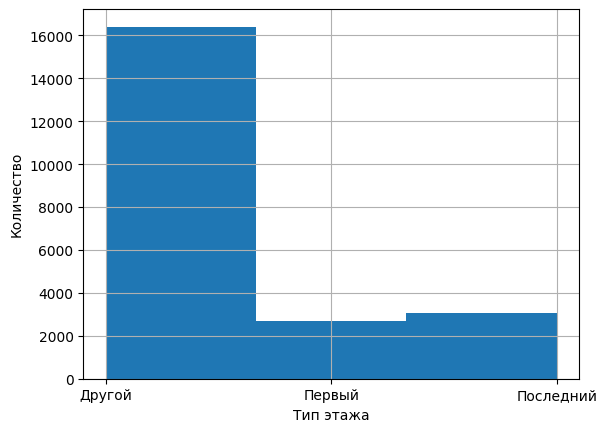

In [366]:
fig, ax = plt.subplots()
ax.set_xlabel('Тип этажа')
ax.set_ylabel('Количество')

data['floor_type'].hist(bins=3)

В параметре "другой" отображены все этажи кроме первого и последнего, поэтому их будет больше.

5.0    5416
9.0    3638
Name: floors_total, dtype: int64

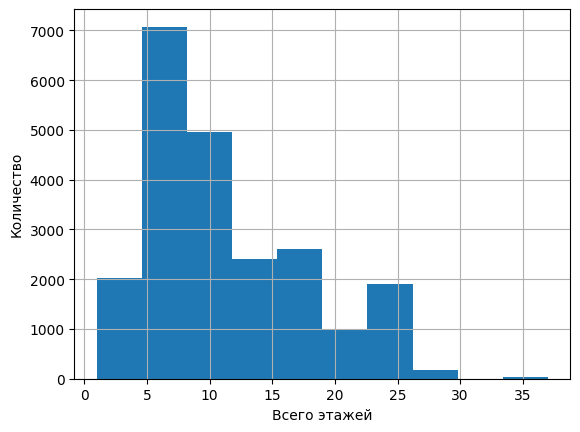

In [367]:
fig, ax = plt.subplots()
ax.set_xlabel('Всего этажей')
ax.set_ylabel('Количество')

data['floors_total'].hist(bins=10)
display(data['floors_total'].value_counts().head(2)) #наибольшее количество домов с этажами:

В распределении четко прослеживаются типовые 5-ти и 9-ти этажки, что похоже на действительную картину.

12348.0

30311.0

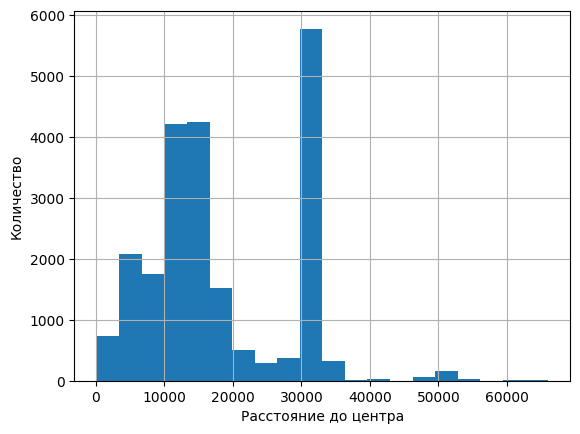

In [368]:
fig, ax = plt.subplots()
ax.set_xlabel('Расстояние до центра')
ax.set_ylabel('Количество')

data['city_centers_nearest'].hist(bins=20)
display(data.query('locality_name == "Санкт-Петербург"')['city_centers_nearest'].median()) #медианное растояние до центра города для Петербурга
display(data.query('locality_name != "Санкт-Петербург"')['city_centers_nearest'].median()) #медианное растояние до центра города для других нас. пунктов

Нормальное распределение удаленности для Санкт-Петербурга и его окресностей с большим выбросом отдаленных населенных пунктов. Это медианное расстояние, которое мы приняли, обрабатывая данные и не находится в зоне в аномалий.

В расчетах было принято два полюса: Петербург - первый пик и само распределение, и другие населенные пункты - второй пик.

- Медианное расстояние до центра Петербурга для Петербурга = 12 348 метров;
- Медианное расстояние до центра Петербурга для других населенных пунктов = 30 311 метров.

26995.0

26618.0

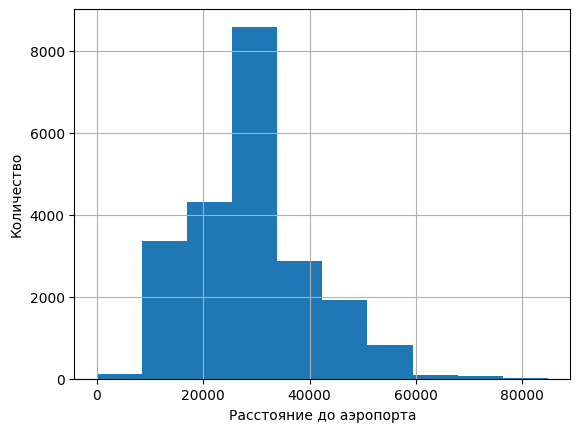

In [369]:
fig, ax = plt.subplots()
ax.set_xlabel('Расстояние до аэропорта')
ax.set_ylabel('Количество')

data['airports_nearest'].hist(bins=10)
display(data.query('locality_name == "Санкт-Петербург"')['airports_nearest'].median()) #медианное растояние до аэропорта для Петербурга
display(data.query('locality_name != "Санкт-Петербург"')['airports_nearest'].median()) #медианное растояние до аэропорта для Петербурга

Расстояние до аэропорта близко к нормальному распределению по своему виду. Есть четкий пик - он один, как для города, так и для его окресностей. Это значит, что аэропорт находится на отдалении от города, иначе картина была бы похожа на предыдущую гистограмму.
- В среднем, расстояние до аэропорта порядка 27 км.

count    7455.000000
mean      491.125285
std       336.507434
min         1.000000
25%       289.500000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

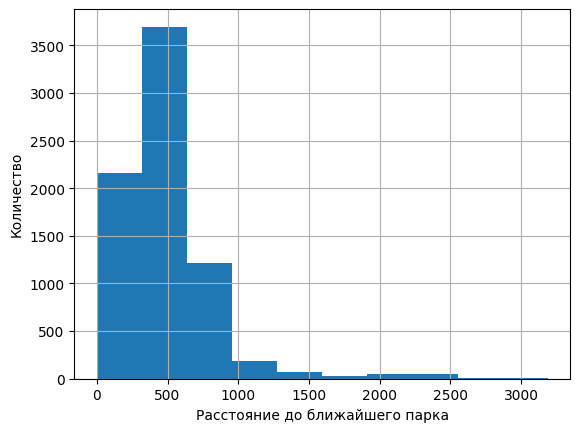

In [370]:
fig, ax = plt.subplots()
ax.set_xlabel('Расстояние до ближайшего парка')
ax.set_ylabel('Количество')

data['parks_nearest'].hist(bins=10)
data['parks_nearest'].describe()

Распределение Пуассона с небольшим "хвостом". Здесь мы не будем искать аномалии в "хвосте", так как данные неполные, информации о расстоянии до ближайшего парка недостаточно, из всей выборки, только 30% данных имеют эту информацию.
- Медианное расстояние до ближайшего парка 456 метров, применимо только для Санкт-Петербурга.

<AxesSubplot:xlabel='День недели', ylabel='Количество'>

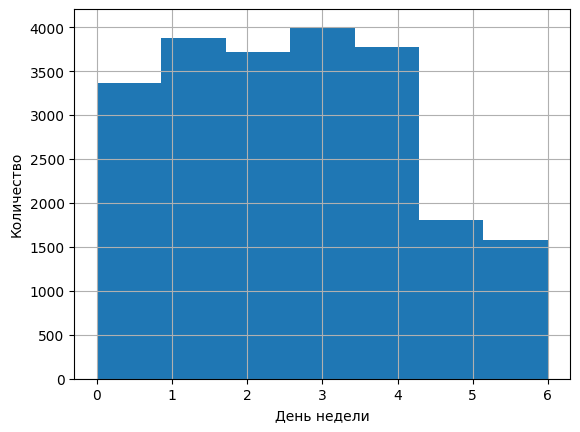

In [371]:
fig, ax = plt.subplots()
ax.set_xlabel('День недели')
ax.set_ylabel('Количество')

data['day'].hist(bins=7)

Четко видно, что основное количество объявлений было в будние дни, тогда как в выходные - примерно в два раза меньше. 

<AxesSubplot:xlabel='Месяц', ylabel='Количество'>

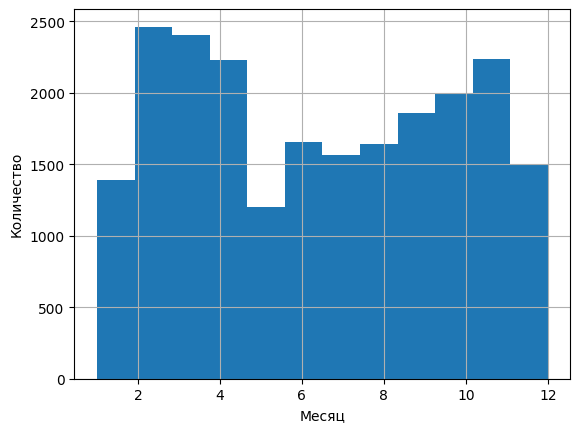

In [372]:
fig, ax = plt.subplots()
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество')

data['month'].hist(bins=12)

Наименьшее количество объявлений в январе, мае и декабре. Наиболее популярные месяцы - февраль и март.

<AxesSubplot:xlabel='Год', ylabel='Количество'>

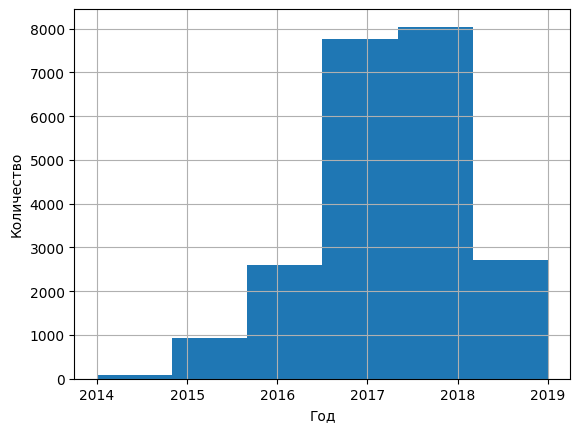

In [373]:
fig, ax = plt.subplots()
ax.set_xlabel('Год')
ax.set_ylabel('Количество')

data['year'].hist(bins=6)

Наименьшее количество объявлений в 2014 году, т.к. это первый год (и скорее всего неполный). Наиболее популярный год - 2018.

#### Как быстро продавались квартиры?

Рассмотрим столбец `days_exposition`:

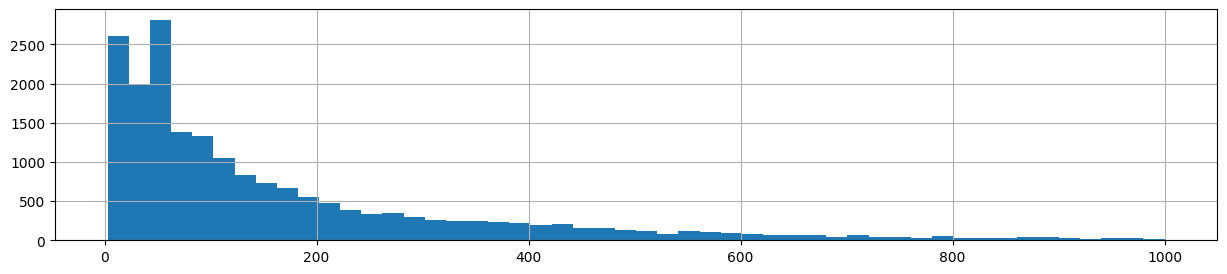

In [374]:
data['days_exposition'].hist(bins = 50, figsize = (15,3));

Гистограмма похожа на распределение Пуассона. Есть два пика, есть смещение вправо. Ознакомимся с описанием `days_exposition`:

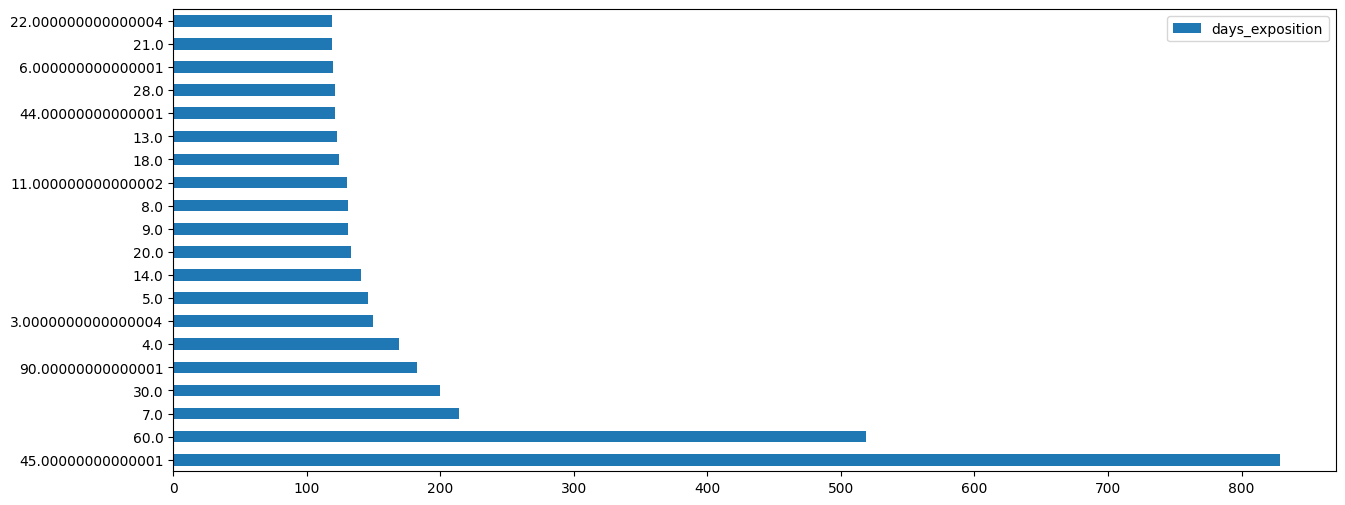

In [375]:
data['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

Наибольшее количество значений приходится на 45 и 60 дней, что можит быть связано с ограничением сайта объявлений. Так как объявление автоматически снимается по достижении этого времени, исключим эти дни для оценки.

In [376]:
data_duration = data.query('days_exposition < 59.9 or days_exposition > 60.1')
data_duration = data_duration.query('days_exposition < 44.9 or days_exposition > 45.1')

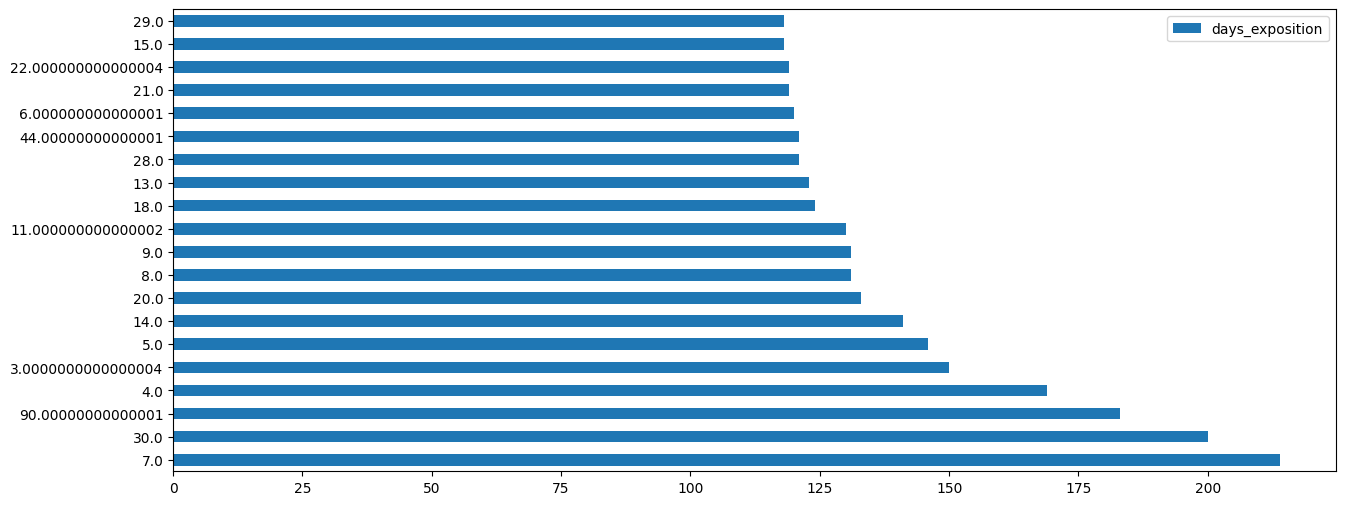

In [377]:
data_duration['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

In [378]:
data_duration['days_exposition'].describe()

count    17819.000000
mean       175.853639
std        191.009906
min          3.000000
25%         41.000000
50%        105.000000
75%        238.000000
max       1000.000000
Name: days_exposition, dtype: float64

Медианное время продажи 105 дней, а среднее - 175 дней. Это значит, что, несмотря на то, что многие квартиры продаются в 105 дней, есть и такие, которые продаются годами. 

Мы убрали выбивающиеся данные из столбца со сроком продажи более 1000 дней.

Быстрой продажей можно считать продажи менее 25%, а это менее 41 дня.

Долгими продажами будут продажи больше 75%, то есть больше 238 дня.

Сколько времени занимала продажа квартиры по медиане.

In [379]:
data.pivot_table(index='year', values='days_exposition', aggfunc='median')

days_exposition
year                 
2014            649.0
2015            497.0
2016            229.0
2017            103.0
2018             64.0
2019             23.0

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Для начала изучим зависимость цены от площадей квартир.
- зависимость стоимости от общей площади;
- зависимость стоимости от жилой площади;
- зависимость стоимости от площади кухни.

Построим графики, проанализируем корреляцию этих данных.

0.7624817335962919

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

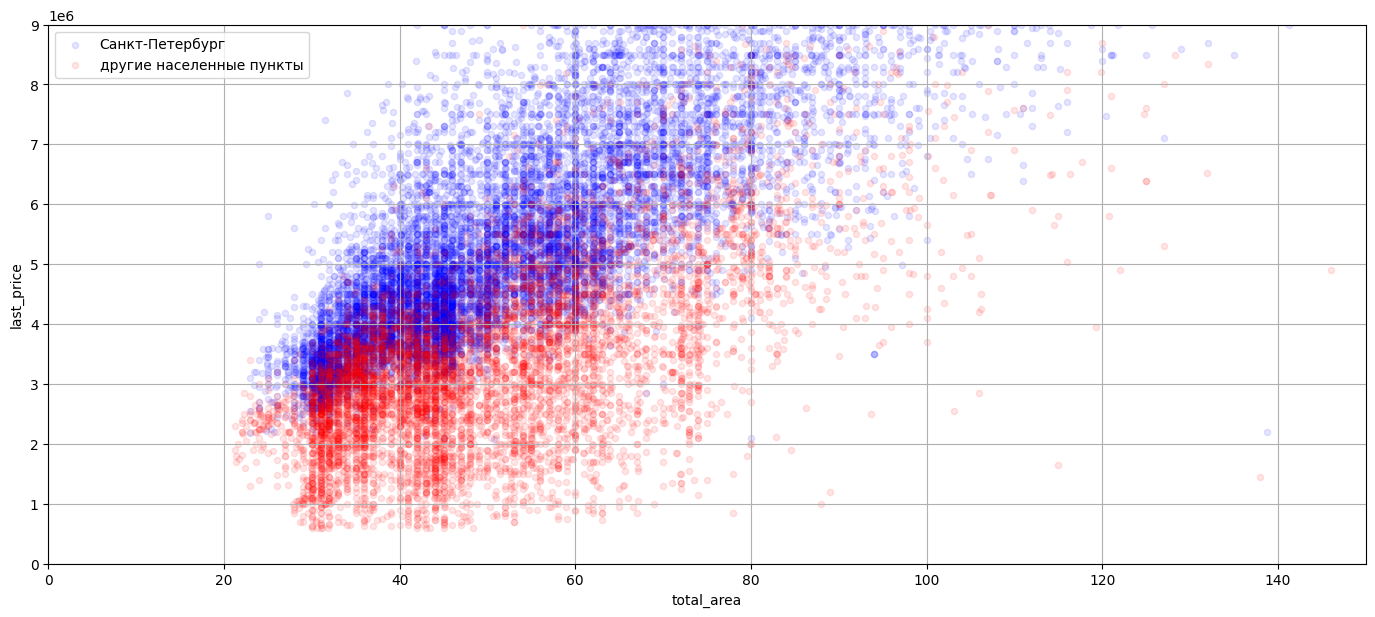

In [380]:
display(data['last_price'].corr(data['total_area'])) #корреляция между столбцами

total_peter_last = data.query('locality_name == "Санкт-Петербург"')
total_not_peter_last = data.query('locality_name != "Санкт-Петербург"')

ax = total_peter_last.plot(x='total_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,150), ylim=(0,9000000), 
          alpha=0.1, c='b', label='Санкт-Петербург')
total_not_peter_last.plot(x='total_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,150), ylim=(0,9000000), 
          alpha=0.1, c='r', ax=ax, label='другие населенные пункты', figsize=(17, 7))


#data.plot(x='total_area', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(0,150), ylim=(0,9000000), alpha=0.05)
#строим диаграмму рассеяния scatter по столбцам total_area и last_price, с ограничениями по x и y, и прозрачностью 0.5, с сеткой
#далее этот код будет повторяться, но с другими параметрами

Корреляция между общей площадью квартиры и ее стоимостью прямопропорциональна, а корреляция довольно высокая (коэффициент Пирсона положительный и ближе к 1, чем к 0. Но стоимость зависит не только от площади, но и от других факторов, таких как населенный пункт, расстояние до города, этаж и т.д.

Но даже несмотря на это, общая площадь квартиры является очень важным фактором формирования стоимости.

0.6491235442353329

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

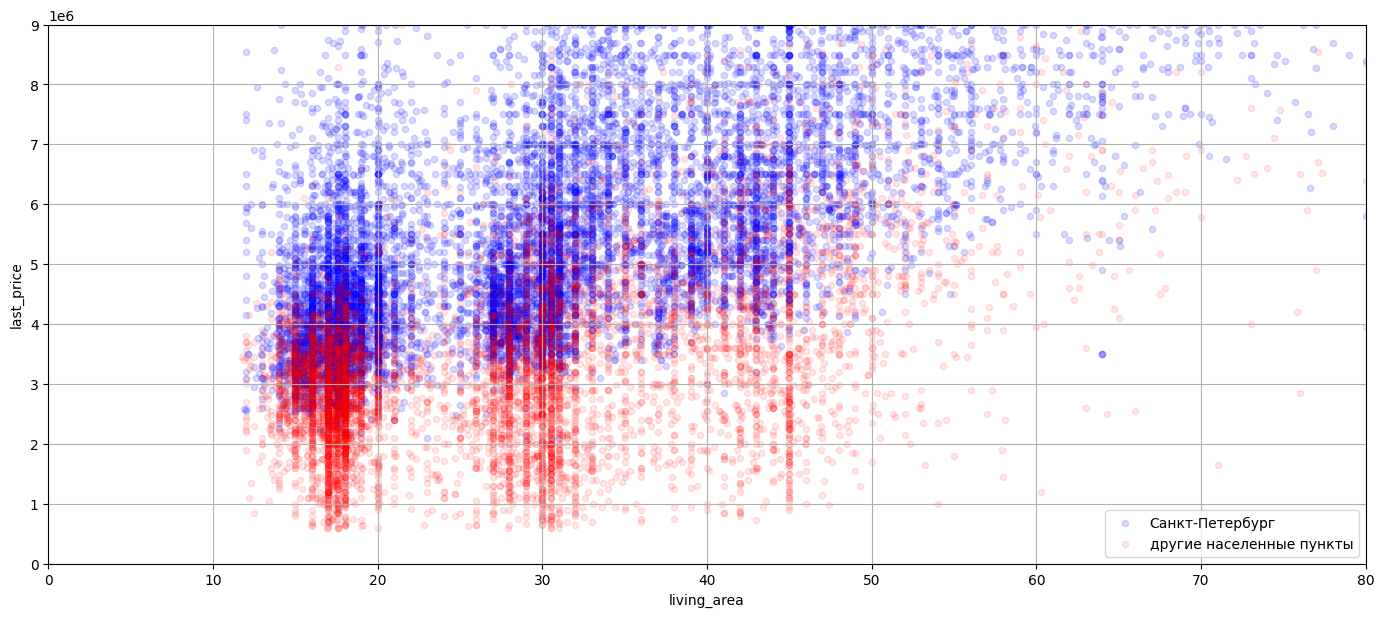

In [381]:
display(data['last_price'].corr(data['living_area'])) #корреляция между столбцами

living_peter_last = data.query('locality_name == "Санкт-Петербург"')
living_not_peter_last = data.query('locality_name != "Санкт-Петербург"')

ax = living_peter_last.plot(x='living_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,80), ylim=(0,9000000), 
          alpha=0.15, c='b', label='Санкт-Петербург')
living_not_peter_last.plot(x='living_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,80), ylim=(0,9000000), 
          alpha=0.1, c='r', ax=ax, label='другие населенные пункты', figsize=(17, 7))

#строим диаграмму рассеяния scatter по столбцам total_area и last_price, с ограничениями по x и y, и прозрачностью 0.5, с сеткой
#далее этот код будет повторяться, но с другими параметрами


#data.plot(x='living_area', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(0,80), ylim=(0,8000000), alpha=0.1)

Корреляция межу жилой площадью и стоимостью квартиры слабее, чем при общей площади, так как:
- во-первых, часть площади квартиры отходит под кухню, 
- во-вторых, общая площадь квартиры - это не только сумма площадей кухни и жилой зоны.

На диаграмме рассеяния видно 3 вертикальные полосы, их значение было рассмотрено выше. Диаграмма рассеяния в целом повторяет данные из гистограммы.

Тем не менее, корреляция средняя, положительная. Связь между стоимостью и площадью жилой зоны есть, она тоже прямопропорциональная.

Повторим эти же действия для площади кухни.

0.5299075942978956

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

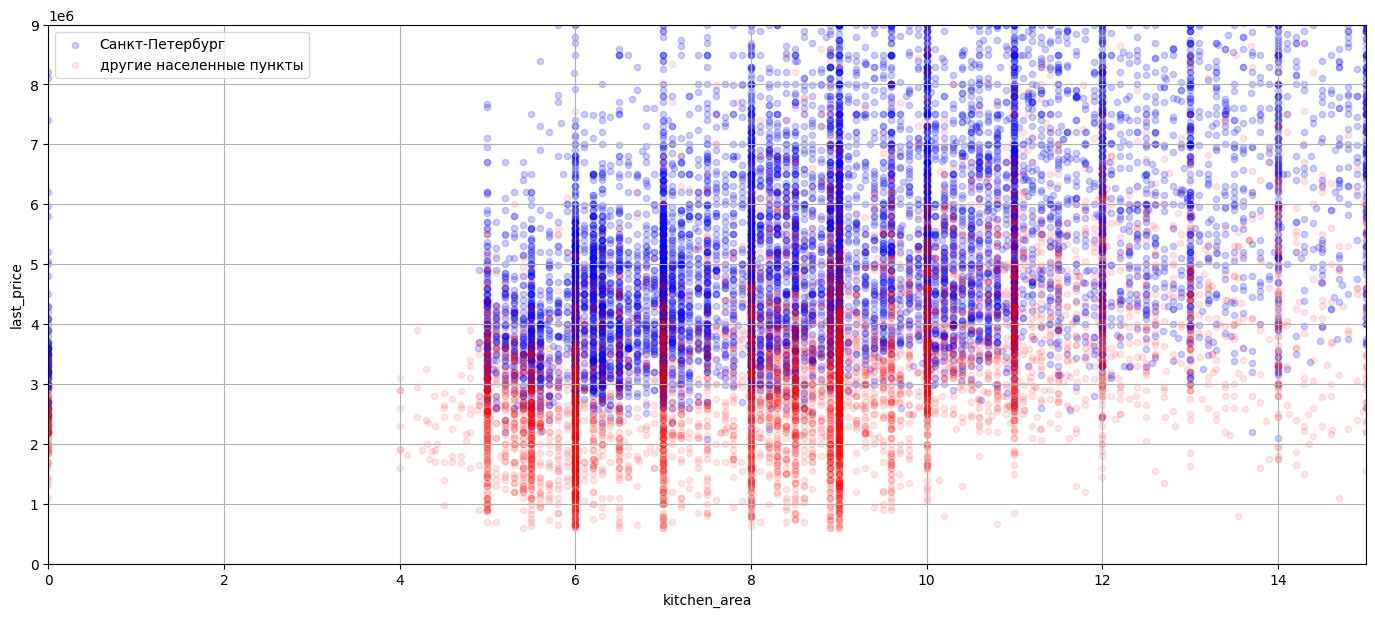

In [382]:
display(data['last_price'].corr(data['kitchen_area'])) #корреляция между столбцами

kitchen_peter_last = data.query('locality_name == "Санкт-Петербург"')
kitchen_not_peter_last = data.query('locality_name != "Санкт-Петербург"')

ax = kitchen_peter_last.plot(x='kitchen_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,15), ylim=(0,9000000), 
          alpha=0.2, c='b', label='Санкт-Петербург')
kitchen_not_peter_last.plot(x='kitchen_area', y='last_price', 
          kind='scatter', sharex=False, grid=True, xlim=(0,15), ylim=(0,9000000), 
          alpha=0.1, c='r', ax=ax, label='другие населенные пункты', figsize=(17, 7))


#data.plot(x='kitchen_area', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(0,20), ylim=(0,9000000), alpha=0.1)

Для зависимости площади кухни и стоимости квартиры коэффициент Пирсона еще меньше, корреляция слабая.

Это говорит скорее о том, что от площади кухни стоимость квартиры почти не зависит, но при этом зависимость прямопропорциональная и корреляция больше 0. Слева видны студии

Далее рассмотрим влияние на стоимость количества комнат в квартире.

0.4624654985954897

<AxesSubplot:xlabel='last_price', ylabel='rooms'>

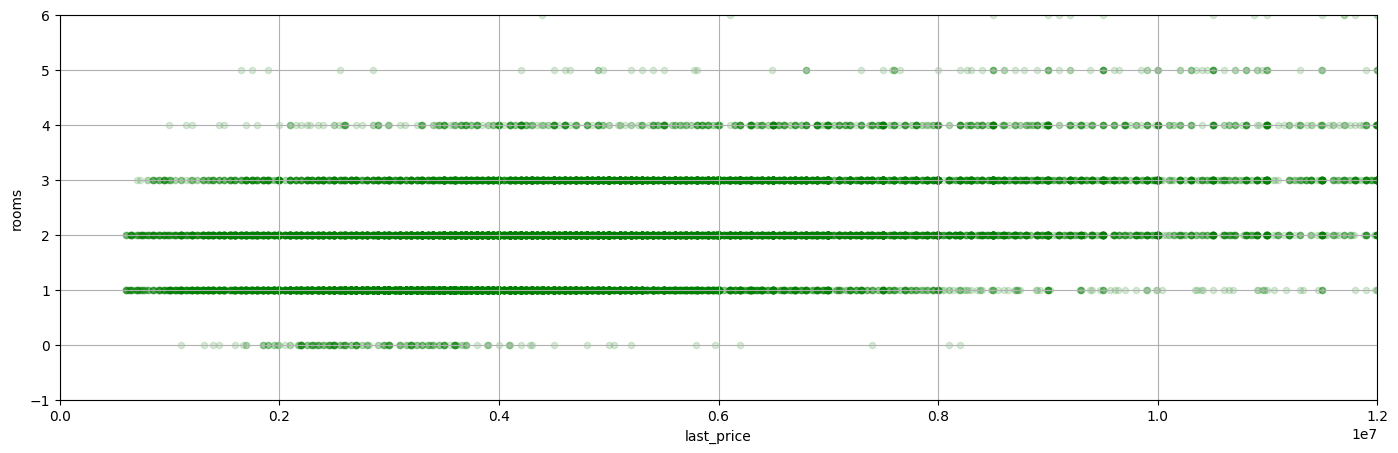

In [383]:
display(data['last_price'].corr(data['rooms']))

data.plot(x='last_price', y='rooms', 
          kind='scatter', sharex=False, grid=True, xlim=(0,12000000), ylim=(-1,6), 
          alpha=0.15, c='g',  figsize=(17, 5))

#data.plot(x='rooms', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(-1,7), ylim=(0,12000000), alpha=0.05)

Так как количество комнат - это дискретное значение, и этих значений всего 7 в этой выборке, диаграмма рассеяния выглядит как столбчатая диаграмма. 

Несмотря на это, именно по этой диаграмме можно сделать интересные выводы.

Начнем с коэффициента корреляции, он довольно низкий (на уровне кухонного). Почему так?

Взглянем на диаграмму:
- квартиры с 0 комнат (студии) - однозначно дешевле пятикомнатных;
- однокомнатные квартиры чаще дешевле четырехкомнатных;

Почему же корреляция слабая? На мой взгляд ответ - двух- и трехкомнатные квартиры. Для них рассеяние выглядит почти абсолютно одинаковым, что уменьшает влияние количества квартир на стоимость. Почему так происходит? Квартиры бывают разными, 50 кв. метров может быть и двухкомнатной, и трехкомнатной. Именно поэтому корреляция общей площади намного сильнее.

Так же на низкое значение корреляции может влиять, например, расположение квартиры. Так, однокомнатная может быть в центре города, а черырехкомнатная в деревне, далеко от города.

Количество комнат не самый объективный показатель для оценки стоимости квартиры.

Рассмотрим влияние категории этажа на стоимость.

Так как корреляцию можно посчитать только с числовым типом данных, переведем тип этажа в числа. Для этого придется создать новый столбец `floor_type_number`, в котором:
- 1 - первый;
- 2 - последний;
- 3 - другой.

Почему последний - это 2, а другой - это 3?

Во-первых, в работе мы рассматриваем первый и последний этаж как краевые случаи, во-вторых, данных этажей меньше, чем всех остальных. Также, следуя собственным знаниям, люди реже всего хотят купить первый, немногим больше - последний, но предпочитают не крайние этажи. Снизу подвал и решетки на окнах, сверху крыша, понимаете.

0.10537044207442069

<AxesSubplot:xlabel='last_price', ylabel='floor_type_number'>

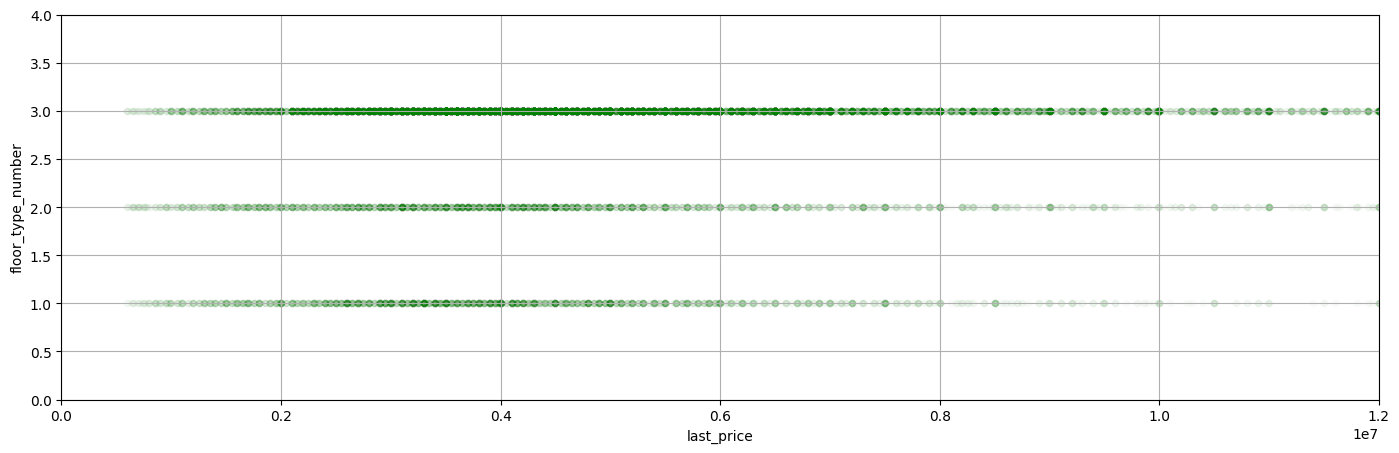

In [384]:
def types(fl): # Создаем функцию
    for i in data['floor_type']: # которая перебирает каждое значение в столбце floor_type
        if fl['floor_type'] == "Первый": # если значение в столбце удовлетворяет условию =='Первый'
            return 1 # то возвращаем значение функции 1
        if fl['floor_type'] == 'Последний': #если значение в столбце удовлетворяет условию =='Последний', 
            return 2 #возвращаем 2
        return 3 #для остальных случаев тип этажа 3

data['floor_type_number'] = data.apply(types, axis=1) #применяем значение к столбцу

display(data['last_price'].corr(data['floor_type_number']))

data.plot(x='last_price', y='floor_type_number', 
          kind='scatter', sharex=False, grid=True, xlim=(0,12000000), ylim=(0,4), 
          alpha=0.02, c='g',  figsize=(17, 5))

#data.plot(x='floor_type_number', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(0,4), ylim=(0,12000000), alpha=0.025)

Корреляция положительная, очень очень слабая. Это значит, что этаж мало влияет на стоимость квартиры. Но по графику мы все же видим, что самые дорогие чаще встречаются на промежуточных этажах, реже на последнем, еще реже - на первом. Все как в реальной жизни. 

Рассмотрим влияние на стоимость квартиры дня недели, месяца и года:

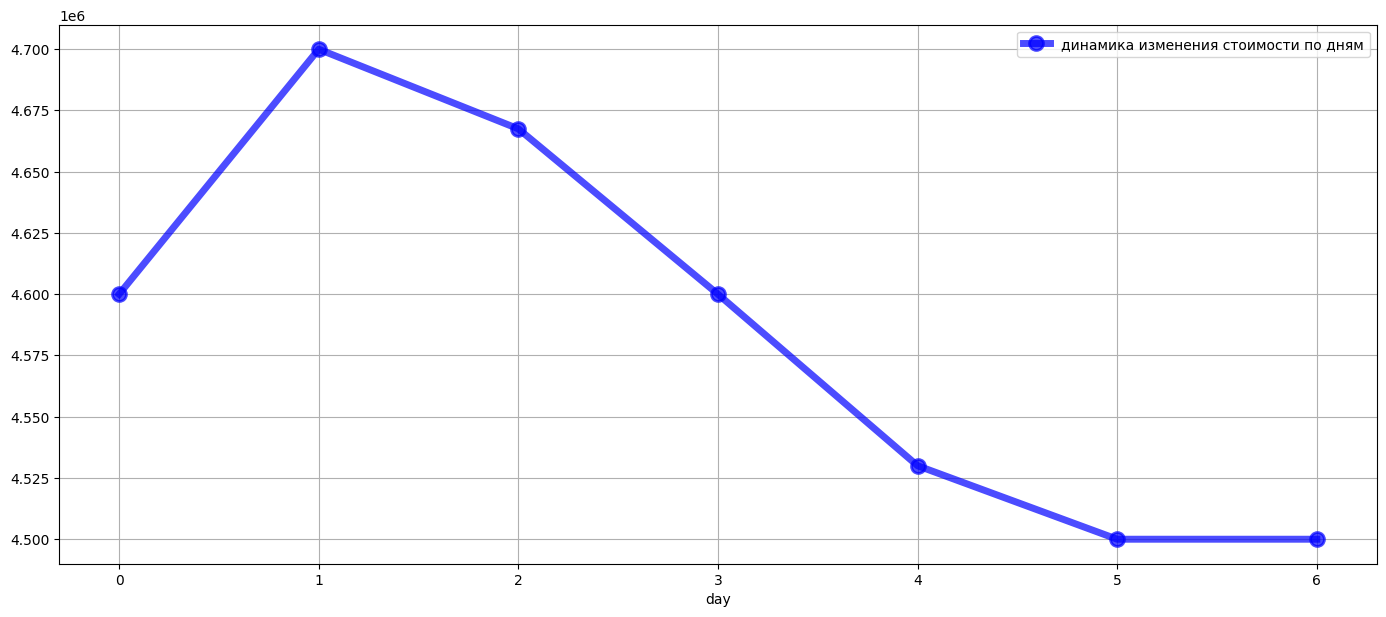

In [385]:
data_for_day = data.groupby('day')['last_price'].median()
plt.figure(figsize=(17, 7))

data_for_day.plot(x='day', y='last_price', style='o-b', alpha=0.7, 
                  label="динамика изменения стоимости по дням", lw=5, mec='b', mew=2, ms=10)
plt.legend()
plt.grid(True)

In [386]:
#display(data['last_price'].corr(data['day']))
#data.plot(x='day', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(-1,7), ylim=(0,12000000), alpha=0.05)

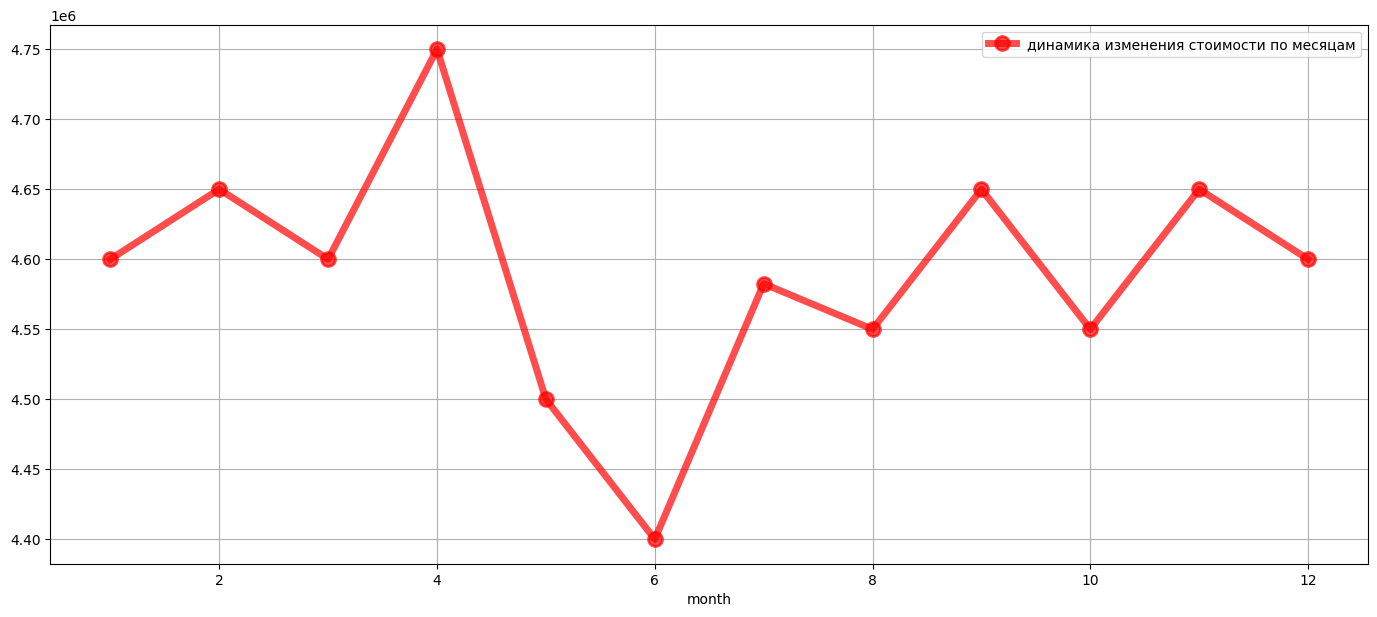

In [387]:
data_for_month = data.groupby('month')['last_price'].median()
plt.figure(figsize=(17, 7))

data_for_month.plot(x='month', y='last_price', style='o-r', alpha=0.7, 
                    label="динамика изменения стоимости по месяцам", lw=5, mec='r', mew=2, ms=10)
plt.legend()
plt.grid(True)

In [388]:
#display(data['last_price'].corr(data['month']))
#data.plot(x='month', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(0,13), ylim=(0,12000000), alpha=0.05)

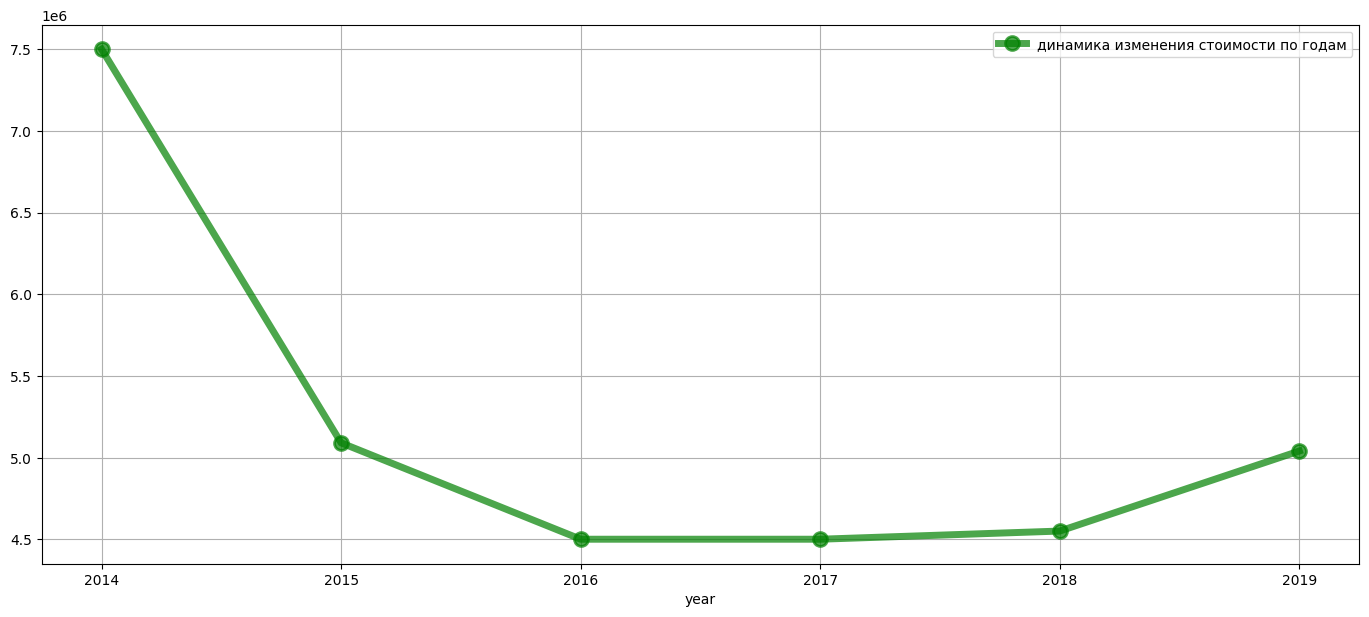

In [389]:
data_for_year = data.groupby('year')['last_price'].median()
plt.figure(figsize=(17, 7))

data_for_year.plot(x='year', y='last_price', style='o-g', alpha=0.7, 
                    label="динамика изменения стоимости по годам", lw=5, mec='g', mew=2, ms=10)
plt.legend()
plt.grid(True)

In [390]:
#display(data['last_price'].corr(data['year']))
#data.plot(x='year', y='last_price', kind='scatter', sharex=False, grid=True, xlim=(2013,2020), ylim=(0,12000000), alpha=0.05)

Согласно полученным данным, самые дорогие квартиры (все считалось по медианам) приходятся на:
- врорник - среди дней недели;
- апрель - сдеди месяцев;
- 2014 год - начало архива объявлений. Может быть некорректная оченка.

Самые дешевые квартиры приходятся на :
- субботу и воскресенье- среди дней недели;
- июнь - сдеди месяцев;
- 2016 и 2017 года.

Подробнее с динамикой цен можно ознакомиться на графиках.

#### Какова стоимость одного квадратного метра?

Для определения стоимости одного кв. метра, соберем 10 самых популярных населенных пунктов:

In [391]:
pop_location = list(data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10).index)
#создаем переменную-список из 10 значений по индексу (т.е. нас. пункту), сгруппированный по нас. пункту, 
#в котором посчитанно кол-во раз, когда нас. пункт встречался в data. список отсортирован в порядке убывания.
data_pop = data.query('locality_name in @pop_location') #создаем таблицу в которой фильтруем названия нас. пункта: только из списка
data_pop = data_pop.groupby('locality_name')['ratio_price'].mean().sort_values(ascending=False).round(2) 
#группируем в этой таблице средние значения стоимости 1 кв. метра по нас. пункту, применяем сортировку по убыванию
display(pd.DataFrame(data_pop))

ratio_price
locality_name                 
Санкт-Петербург      111987.18
Пушкин               101115.64
Кудрово               95101.98
поселок Парголово     90030.56
Мурино                85348.23
поселок Шушары        78205.22
Колпино               75400.77
Гатчина               68649.53
Всеволожск            67111.50
Выборг                57806.09

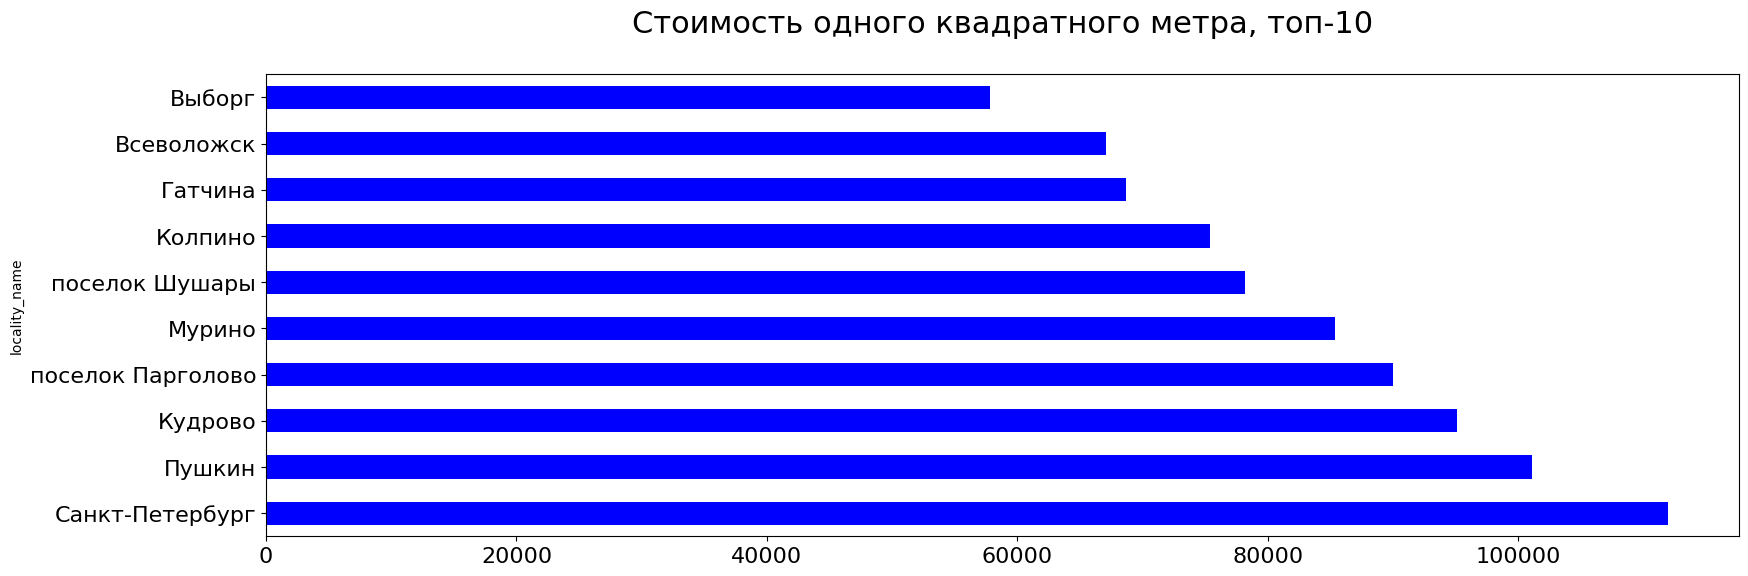

In [392]:
data_pop.plot(kind= 'barh', figsize=(19,6), legend = False, fontsize = 16, color='b')\
.set_title('Стоимость одного квадратного метра, топ-10' + "\n", fontsize = 22, color = 'Black');

In [393]:
display(f'По результатам расчета, среди самых популярных по объявлениям о продаже населенных пунктов,\
максимальная стоимость 1 кв. метра в городе {data_pop.index[0]} и составляет {data_pop[0].round(2)}')
display(f'Самым недорогим местом оказался {data_pop.index[9]} со стоимостью {data_pop[9].round(2)} за 1 кв. метр')       

'По результатам расчета, среди самых популярных по объявлениям о продаже населенных пунктов,максимальная стоимость 1 кв. метра в городе Санкт-Петербург и составляет 111987.18'

'Самым недорогим местом оказался Выборг со стоимостью 57806.09 за 1 кв. метр'

In [394]:
data_price_km = data.query('locality_name == "Санкт-Петербург"').groupby('distance')['last_price'].mean() 
#среди данных, локация которых Ст. Петербург, группируем по расстоянию и выводим среднюю цену.
data_price_km = pd.DataFrame(data_price_km) #преобразовываем в датафрейм
data_price_km.columns = ['price_per_km'] #присваиваем имя для столбца
data_price_km['distance_peter'] = data_price_km.index
display(data_price_km) #выводим ДФ

price_per_km  distance_peter
distance                              
0         1.754883e+07               0
1         1.268416e+07               1
2         1.268260e+07               2
3         1.000283e+07               3
4         1.088597e+07               4
5         1.164535e+07               5
6         1.180484e+07               6
7         1.253870e+07               7
8         8.849816e+06               8
9         6.989493e+06               9
10        6.410588e+06              10
11        6.009376e+06              11
12        5.994384e+06              12
13        6.032364e+06              13
14        5.550769e+06              14
15        5.740870e+06              15
16        5.333282e+06              16
17        5.231840e+06              17
18        4.933500e+06              18
19        5.069466e+06              19
20        5.962165e+06              20
21        5.492988e+06              21
22        5.393685e+06              22
23        4.711827e+06              23
24        3.854430e+06              24
25        4.100714e+06              25
26        4.192545e+06              26
27        8.300000e+06              27
28        5.026429e+06              28
29        4.236667e+06              29

Мы видим, что есть небольшая тенденция спада стоимости 1 кв. метра относительно расстояния до центра города.

Построим столбчатую диаграмму и узнаем значение корреляции:

-0.8153023492617972

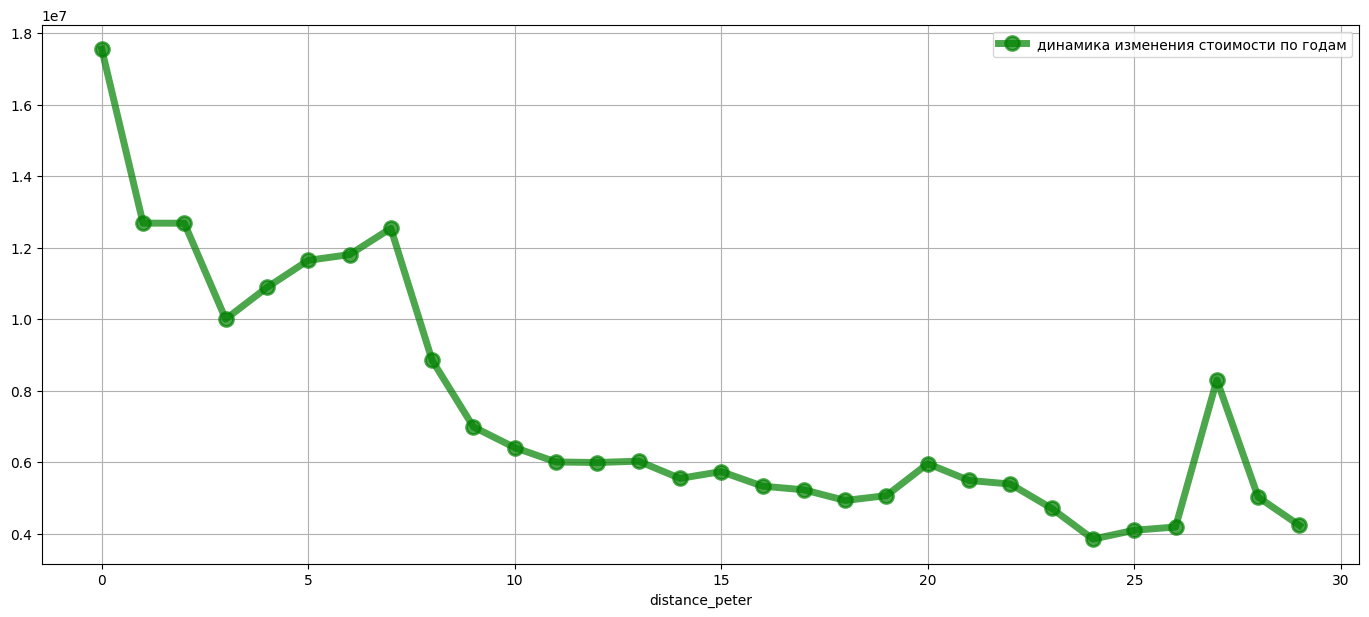

In [395]:
display(data_price_km['distance_peter'].corr(data_price_km['price_per_km'])) #корреляция между расстоянием до центра и стоимостью кв. метра

price_km = data_price_km.groupby('distance_peter')['price_per_km'].median()
plt.figure(figsize=(17, 7))

price_km.plot(x='distance_peter', y='price_per_km', style='o-g', alpha=0.7, 
                    label="динамика изменения стоимости по годам", lw=5, mec='g', mew=2, ms=10)
plt.legend()
plt.grid(True)

#seaborn.barplot(data=data_price_km, x=data_price_km.index, y=data_price_km['meter_price_per_km'])

Корреляция очень высокая, отрицательная. Это значит, что чем дальше от центра, тем ниже стоимость одного квадратного метра.

Функция убывающая, имеются отклонения. Может быть связано с элитной недвижимостью, дорогим районом Петербурга или большими квартирами (например, на удаленни 7 километров от центра много предложений с большими квартирами. Есть выбивающиеся значения на правой границе графика (удаленные объекты).

В любом случае - чем дальше от центра, при прочих равных условиях, цена будет нихе. Это также прослеживается на реальных данных.

In [396]:
data

total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00           2019-03-07      3   
1                 7   3350000.0       40.40           2018-12-04      1   
2                10   5196000.0       56.00           2015-08-20      2   
3                 0  64900000.0      159.00           2015-07-24      3   
4                10   2890000.0       30.40           2018-09-10      1   
...             ...         ...         ...                  ...    ...   
22127             9   9700000.0      133.81           2017-03-21      3   
22128            14   3100000.0       59.00           2018-01-15      3   
22129            18   2500000.0       56.70           2018-02-11      2   
22130            13  11475000.0       76.75           2017-03-28      2   
22131             4   1350000.0       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70          16.0       51.000      8         False  ...   
1                2.60          11.0       18.600      1         False  ...   
2                2.64           5.0       34.300      4         False  ...   
3                2.64          14.0       45.000      9         False  ...   
4                2.60          12.0       14.400      5         False  ...   
...               ...           ...          ...    ...           ...  ...   
22127            3.70           5.0       73.300      3         False  ...   
22128            2.60           5.0       38.000      4         False  ...   
22129            2.60           3.0       29.700      1         False  ...   
22130            3.00          17.0       45.775     12         False  ...   
22131            2.50           5.0       12.300      1         False  ...   

         delta  is_peterburg  delta_floor    ratio_price day  month  year  \
0       32.000          True          8.0  120370.370370   3      3  2019   
1       10.800         False         10.0   82920.792079   1     12  2018   
2       13.400          True          1.0   92785.714286   3      8  2015   
3      104.400          True          5.0  408176.100629   4      7  2015   
4        6.900         False          7.0   95065.789474   0      9  2018   
...        ...           ...          ...            ...  ..    ...   ...   
22127   46.680          True          2.0   72490.845228   1      3  2017   
22128   12.500         False          1.0   52542.372881   0      1  2018   
22129    5.670         False          2.0   44091.710758   6      2  2018   
22130    7.675          True          5.0  149511.400651   1      3  2017   
22131   11.000         False          4.0   41795.665635   4      7  2017   

       floor_type  distance  floor_type_number  
0          Другой        16                  3  
1          Первый        19                  1  
2          Другой        14                  3  
3          Другой         7                  3  
4          Другой        30                  3  
...           ...       ...                ...  
22127      Другой         4                  3  
22128      Другой        30                  3  
22129      Первый        30                  1  
22130      Другой        10                  3  
22131      Первый        30                  1  

[22132 rows x 32 columns]

### Общий вывод

#### Предобработка данных

На этапе предобработки данны были решены следующие проблемы:

- были заполнены пропуски, где это было возможно;
- были преобразованы типы данных, где это было возможно;
- датасет был проверен на явные дубликаты;
- были устранены неявные дубликаты;
- были устранены анамалии, как вручную, так и автоматическими методами.

#### Добавление данных

На этапе добавления данных были созданы необходимые для решения столбцы с данными.  

#### Исследовательский анализ данных

На этапе анализа данных былы показаны гистограммы каждого параметра, который может влиять на конечный результат. 

Описано поведение данных для каждого случая, приведены результаты некоторых наблюдений. Например, скольки этажные дома встречаются чаще всего и т.д.

Было описано медианное и среднее количество дней при продаже квартиры, а также дан ответ на вопрос: какие продажи можно считать быстрыми, а какие - долгими?

Были разобраны различные источники влияния на конечную стоимость квартиры:

- Каково влияние общей площади квартиры на ее стоимость? Каково влияние только жилой площади? Площади кухни? Каково влияние количества комнат?

Выяснилось, что наибольшее влияние оказывает общая площадь квартиры, тогда как отдельные площади хоть и влияют на стоимость, но гораздо слабее. Это происходит вследствие того, что квартира (по площади) - это не отдельно кухня, отдельно жилая зона, а целый комплекс площадей, в котором площадь кухни и жилой зоны - только часть общей площади. Количество комнат - это обычно побочный параметр от площади.

- Влияет ли этаж на стоимость квартиры?

Этаж влияет, но это не один из главных параметров в оценке квартиры. Но, первый этаж точно дешевле.

- Влияет ли каким-то образом дата размещения объявления? День недели? Месяц? Год?

Были найдены зависимости цены от дня/месяца/года и построены графики.

Были найдены 10 самых популярных населенных пунктов по продаже квартир, а среди них найдена средняя стоимость одного квадратного метра. Не удивительно, что лидером стал город Санкт-Петербург.

Найдена зависимость стоимости недвижимости от удаления от центра города для Санкт-Петербурга. В этом случае была максимально объективная оценка по стоимости, т.к. расчеты производились для одного населенного пункта. Но без колебаний зависимости не обошлось. Так, в районе 7 километров обнаружилась дорогая недвижимость. 

Результат - очень высокая отрицательная корреляция. Чем ближе к центру города, тем выше стоимость одного квадратного метра.

Больше всего на стоимость влияют такие параметры как:
- общая площадь;
- населенный пункт;
- удаленность от центра.

Также влияют (но с оговорками или слабее):
- количество комнат (но комнат может быть разное количество при одинаковой площади, корреляция ниже, чем для общей площади);
- этаж. Первый дешевле последнего, а последний дешевле остальных. Но этаж все равно очень слабо влияет на стоимость.